# Introduction

This notebook generates aggregated traces based on seven synthetic traces that follow typical patterns in cloud computing. The original traces have the values per second and they will be aggregated with three window sizes (5, 15, and 60 minutes) and two aggregation functions (max and sum). In addition, there will be files with only one app and with two apps, using the combinations of the seven traces.

In [1]:
import itertools
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
traces = [
    "decreasing",
    "increasing",
    "periodic",
    "unpredictable",
    "everything",
    "once",
    "static",
]

df_sec = {}
for trace in traces:
    file_name = f"wl_{trace}_1s.csv"
    df_sec[trace] = pd.read_csv(file_name, header=None, names=["reqs"])
    df_sec[trace].index = pd.to_datetime(df_sec[trace].index, unit="s")

In [3]:
df_sec["once"].head()

,reqs
1970-01-01 00:00:00,40
1970-01-01 00:00:01,39
1970-01-01 00:00:02,40
1970-01-01 00:00:03,32
1970-01-01 00:00:04,39


In [4]:
window_sizes_min = [5, 15, 60]

df_agg = {trace: {} for trace in traces}
for trace in traces:
    for window_size_min in window_sizes_min:
        window_size_str = f"{window_size_min}T"

        df_agg[trace][(window_size_min, "max")] = (
            df_sec[trace].resample(window_size_str).max() * 60 * window_size_min
        )
        df_agg[trace][(window_size_min, "max")].to_csv(
            f"wl_{trace}_max_{window_size_min}t.csv"
        )

        df_agg[trace][(window_size_min, "sum")] = (
            df_sec[trace].resample(window_size_str).sum()
        )
        df_agg[trace][(window_size_min, "sum")].to_csv(
            f"wl_{trace}_sum_{window_size_min}T.csv"
        )

In [5]:
# Create combinations of traces for two apps
NUM_APPS = 2
traces_app_scenario = list(itertools.combinations(traces, NUM_APPS))

df_agg_2apps = {trace: {} for trace in traces_app_scenario}
for trace1, trace2 in traces_app_scenario:
    for window_size_min in window_sizes_min:
        window_size_str = f"{window_size_min}T"
        for agg_func in ["max", "sum"]:
            new_df = pd.concat(
                [
                    df_agg[trace1][(window_size_min, agg_func)],
                    df_agg[trace2][(window_size_min, agg_func)],
                ],
                axis=1,
            )
            new_df.index.name = "datetime"
            new_df.columns = ["app0", "app1"]
            new_df.to_csv(
                f"wl_2apps_{trace1}_{trace2}_{window_size_min}T_{agg_func}.csv"
            )
            df_agg_2apps[(trace1, trace2)][(window_size_min, agg_func)] = new_df

# Compare window sizes

/tmp/ipykernel_2641/1190192099.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(17, 5))


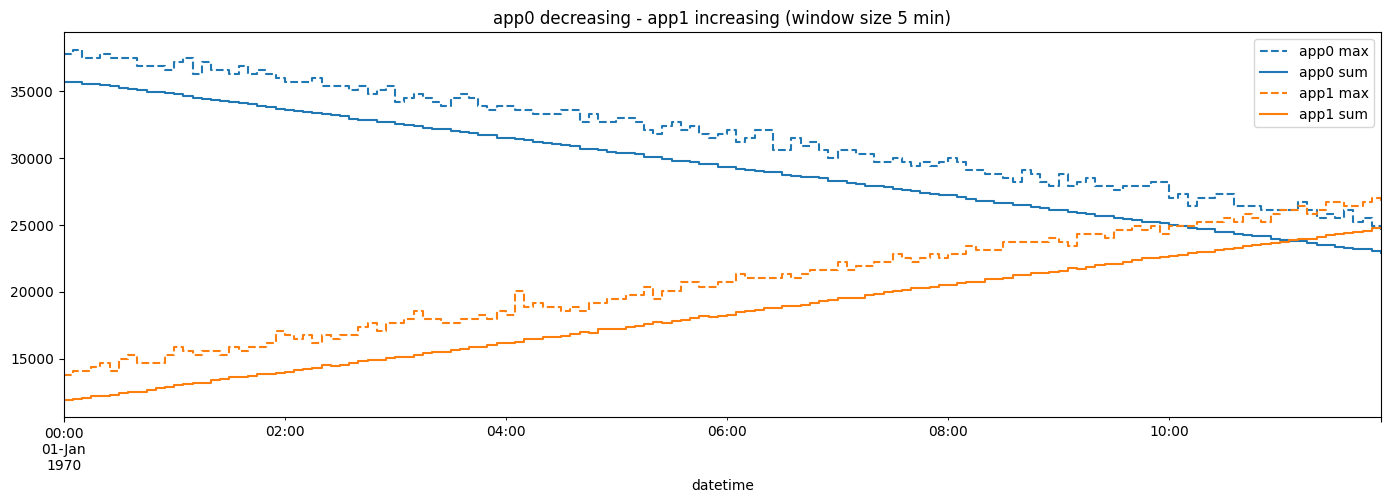

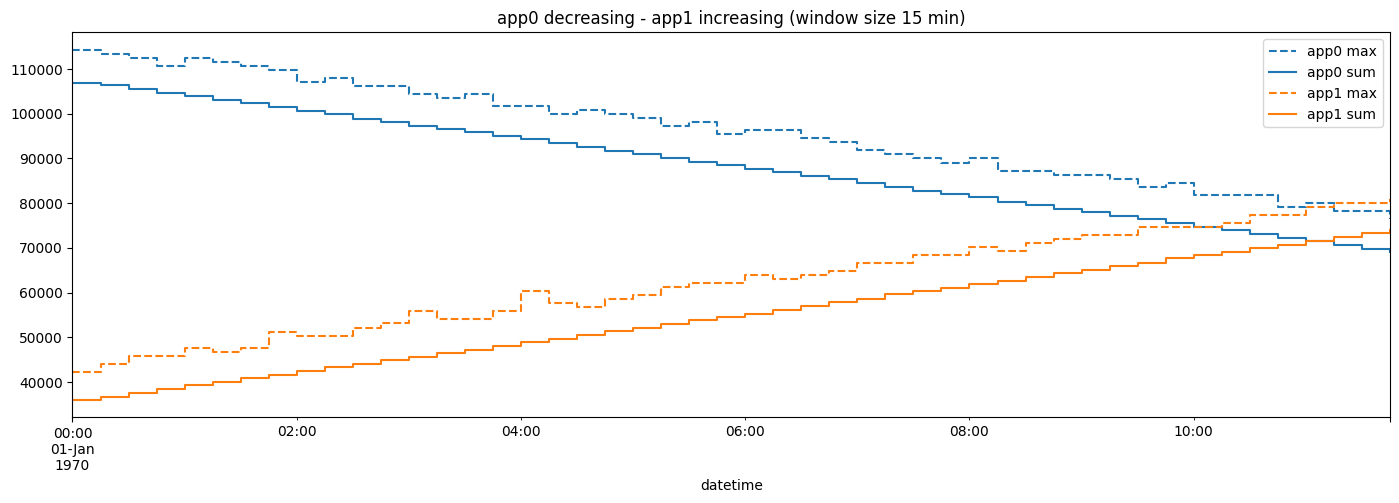

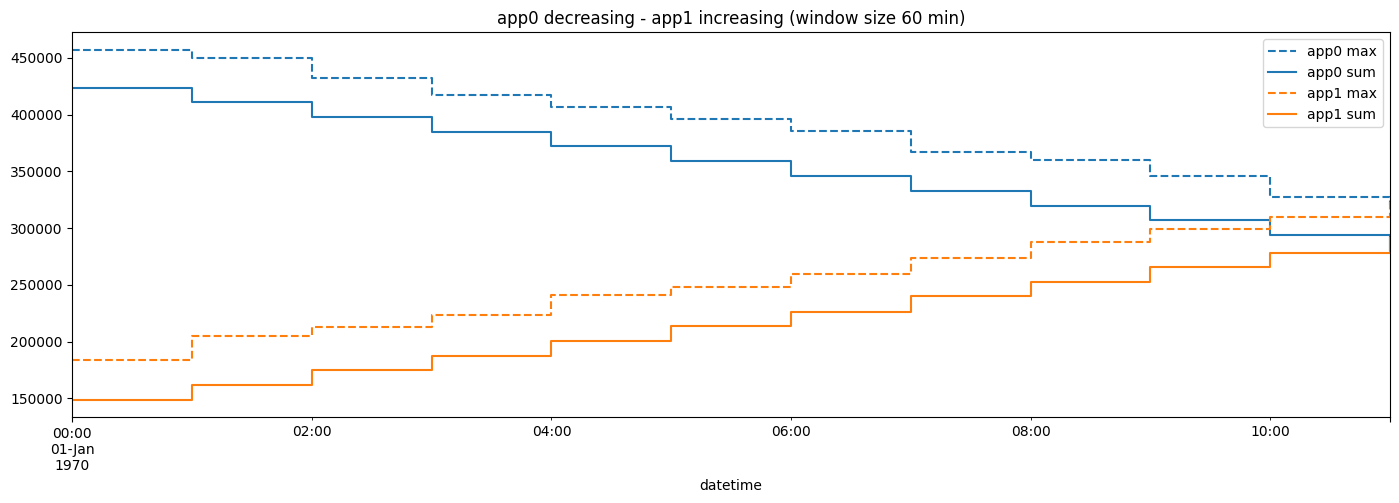

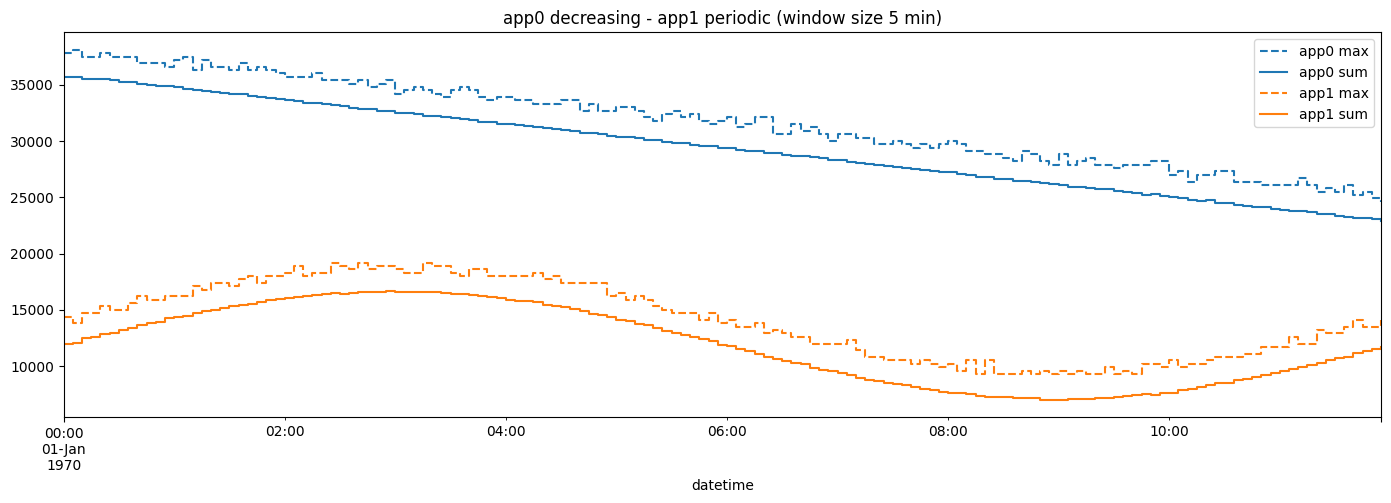

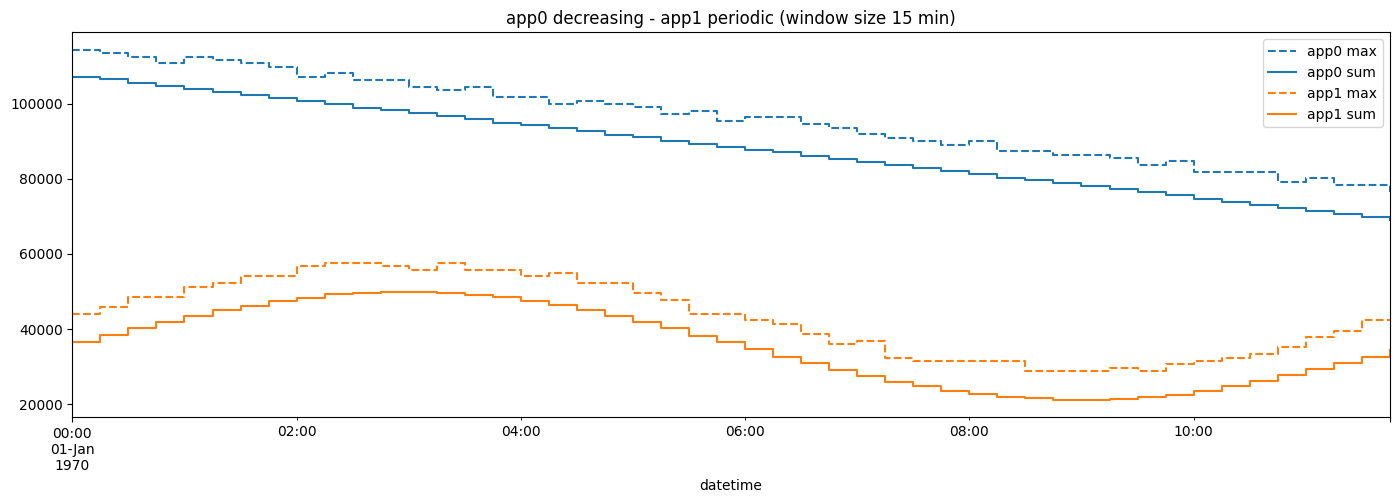

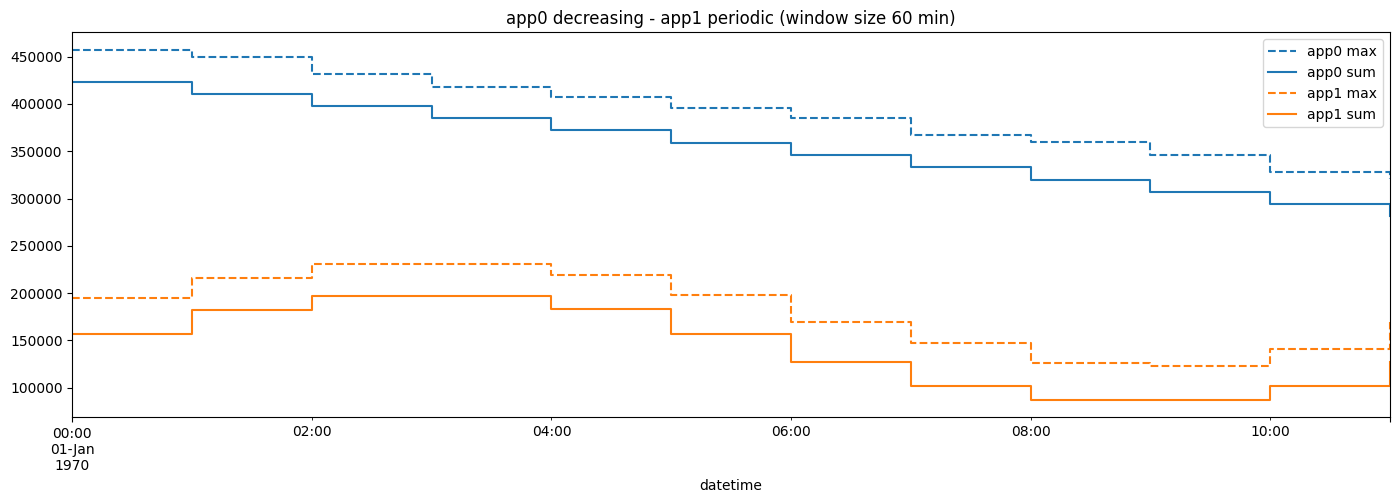

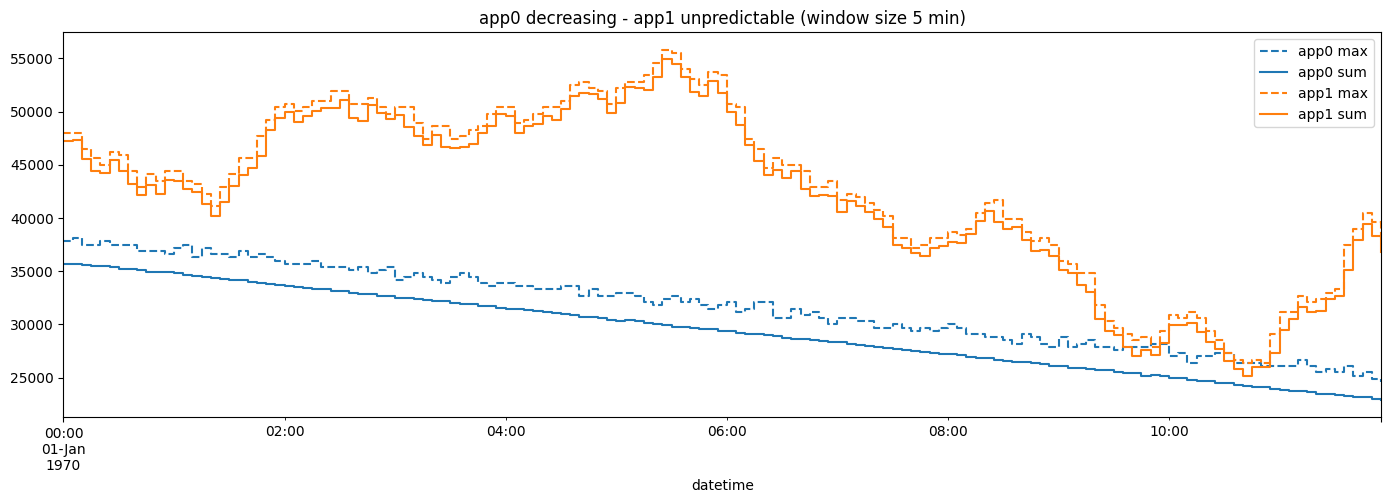

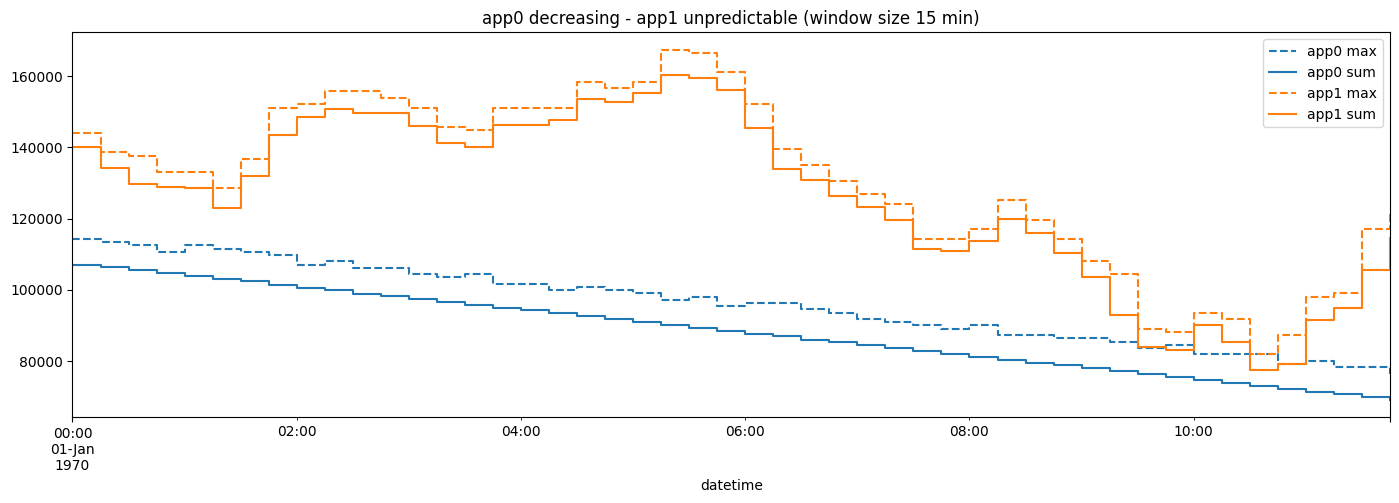

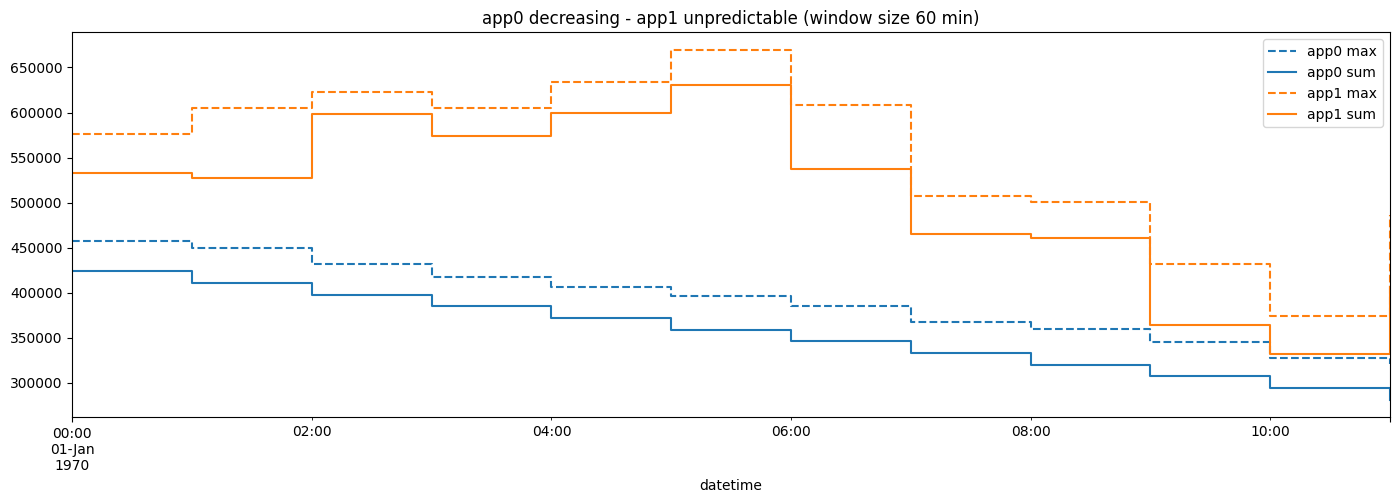

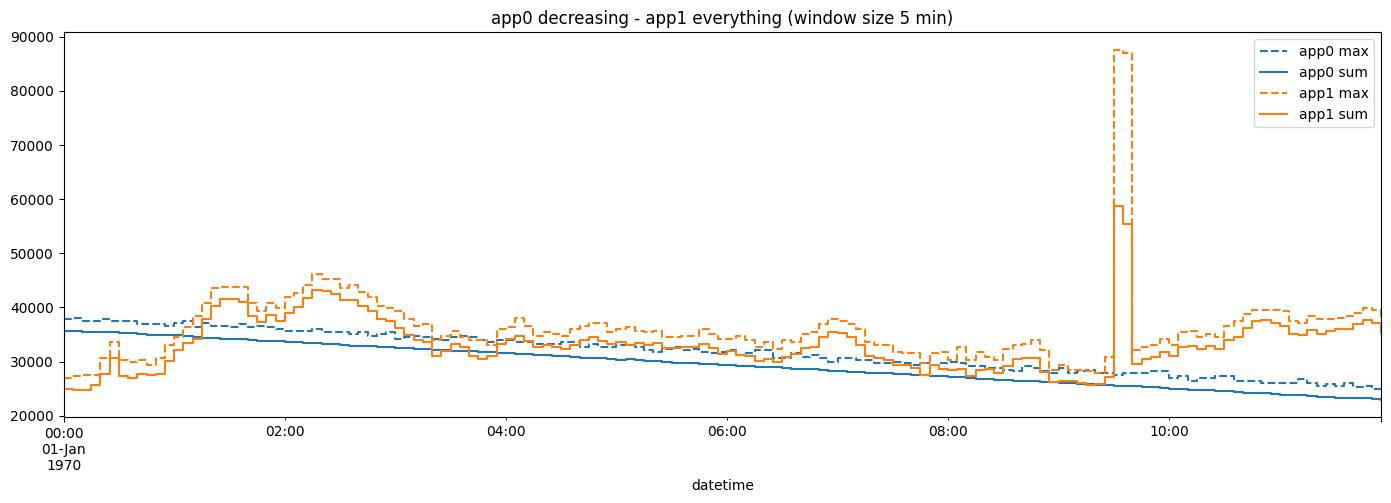

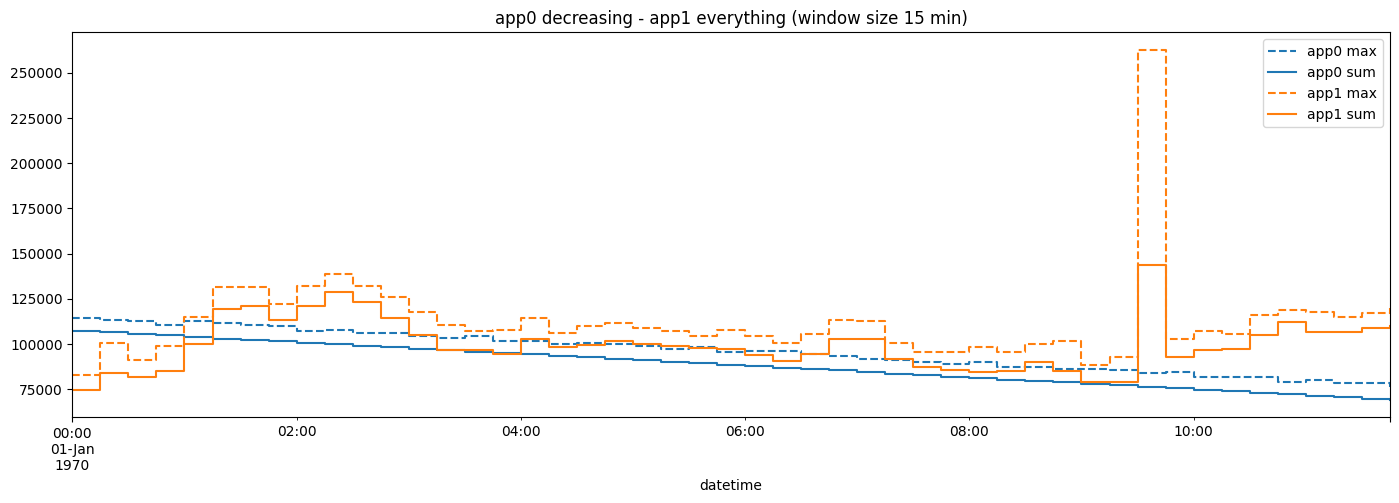

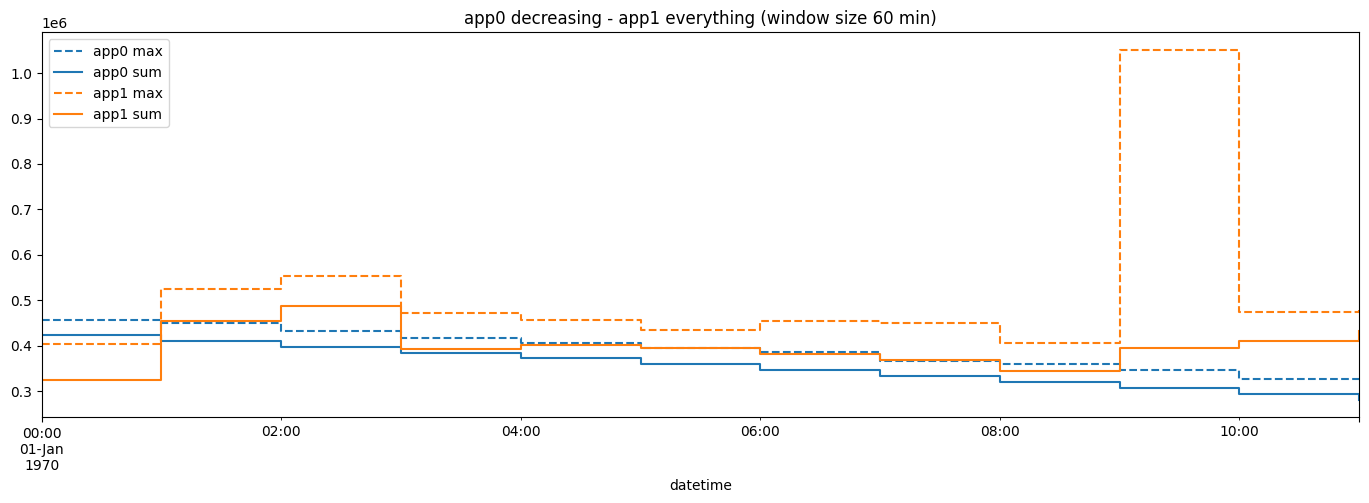

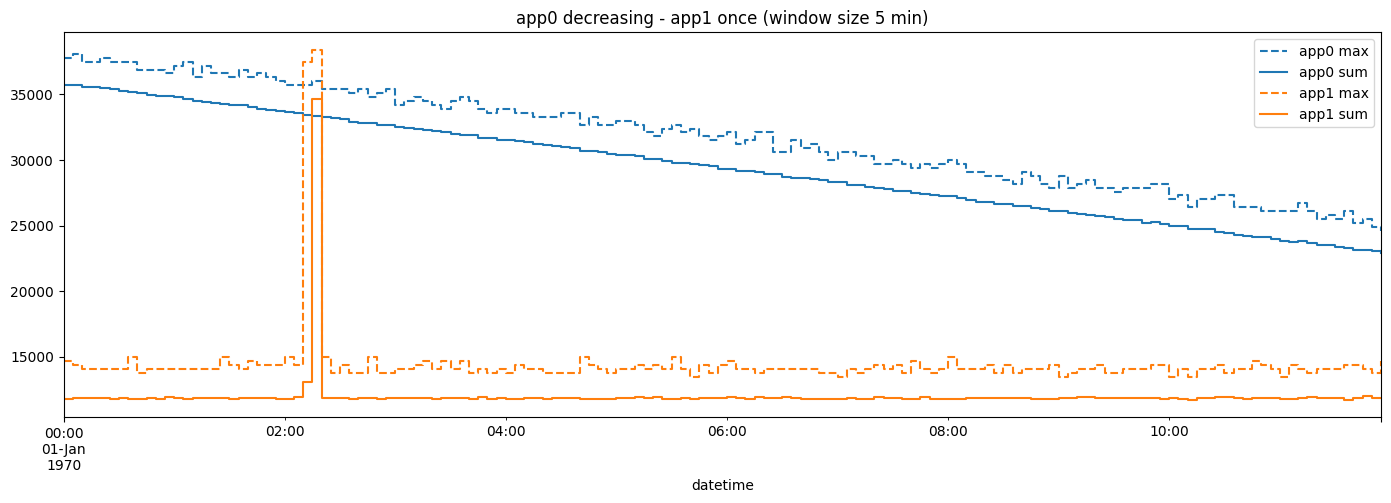

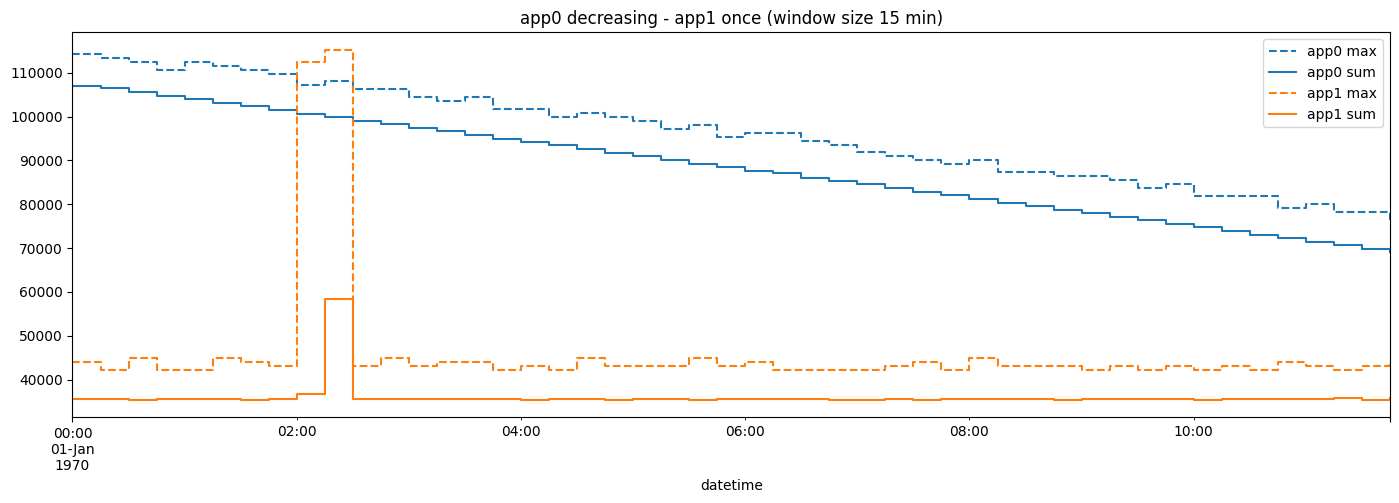

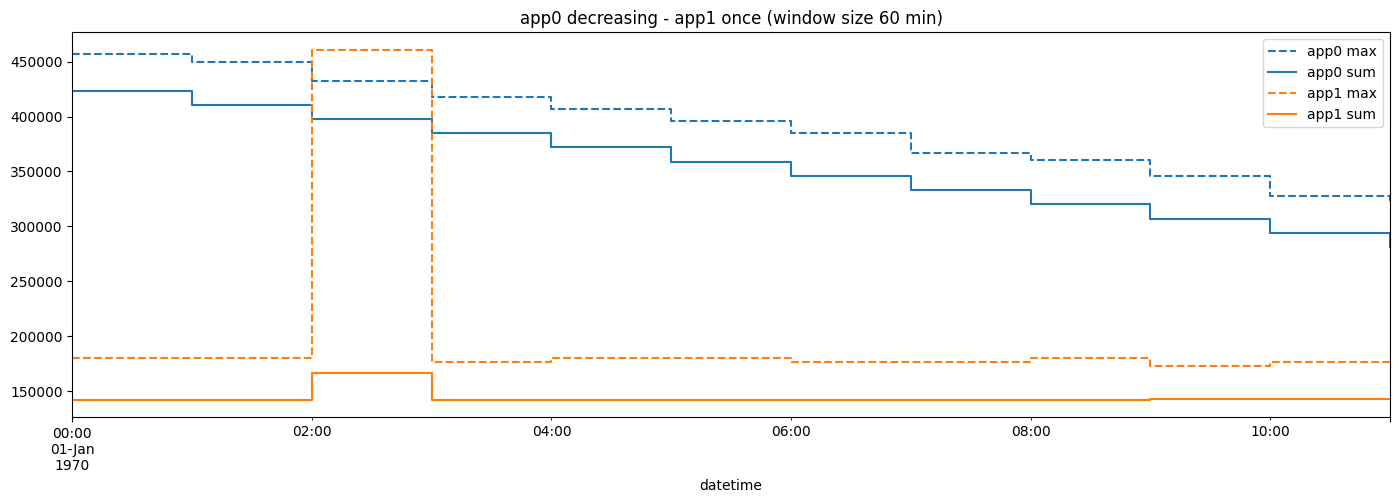

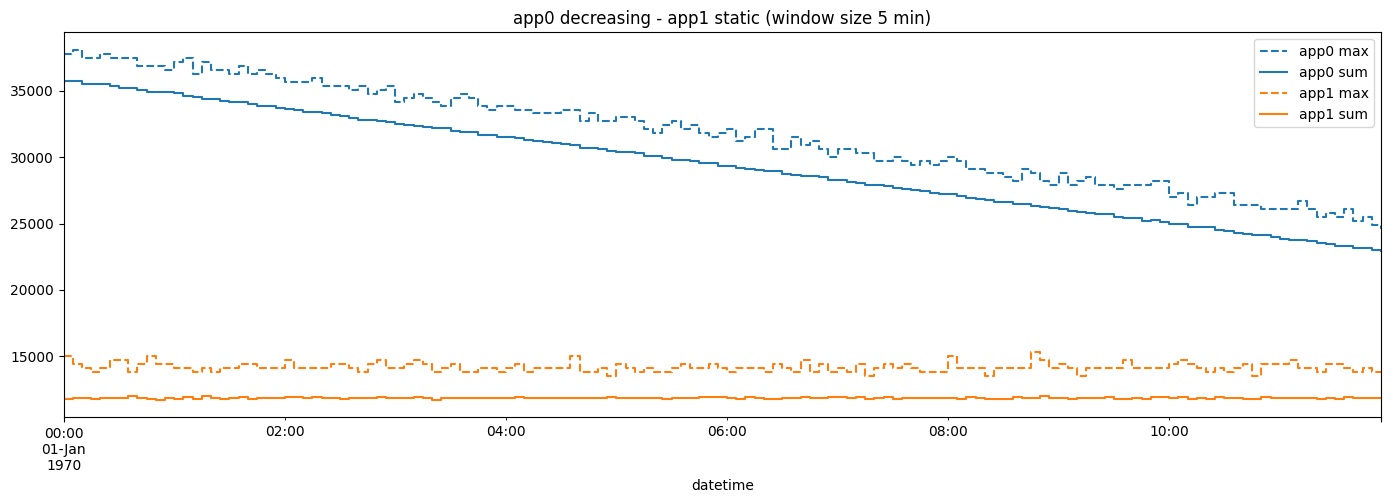

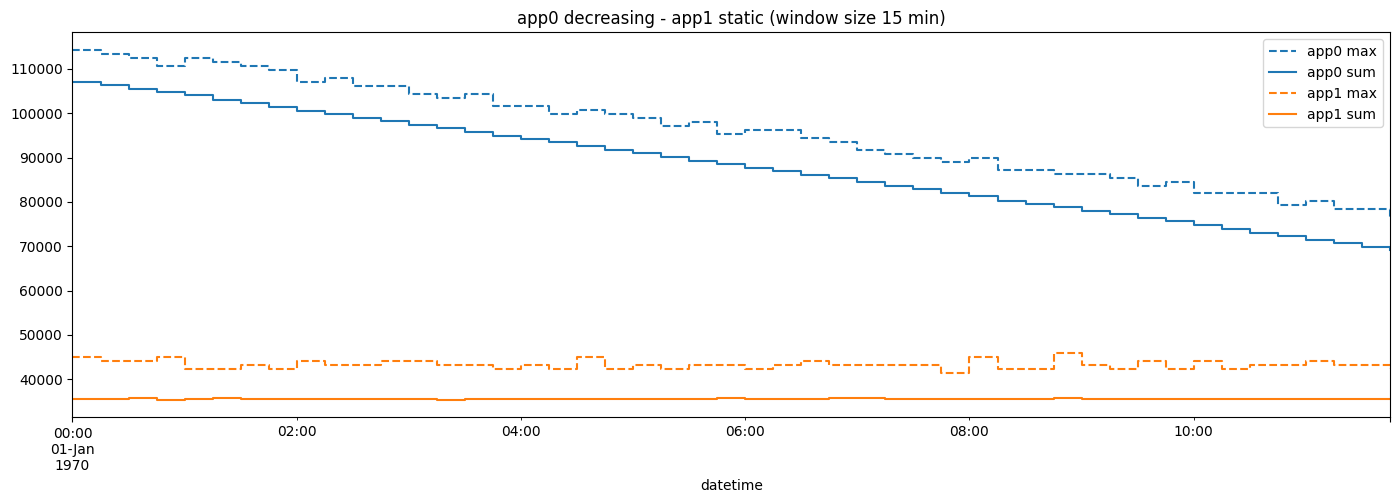

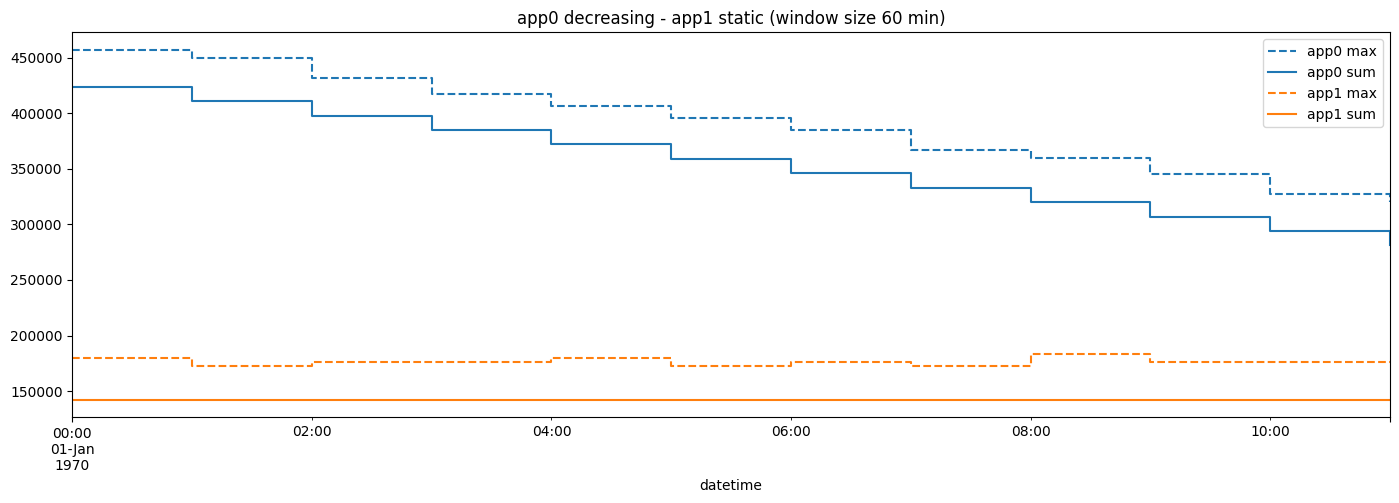

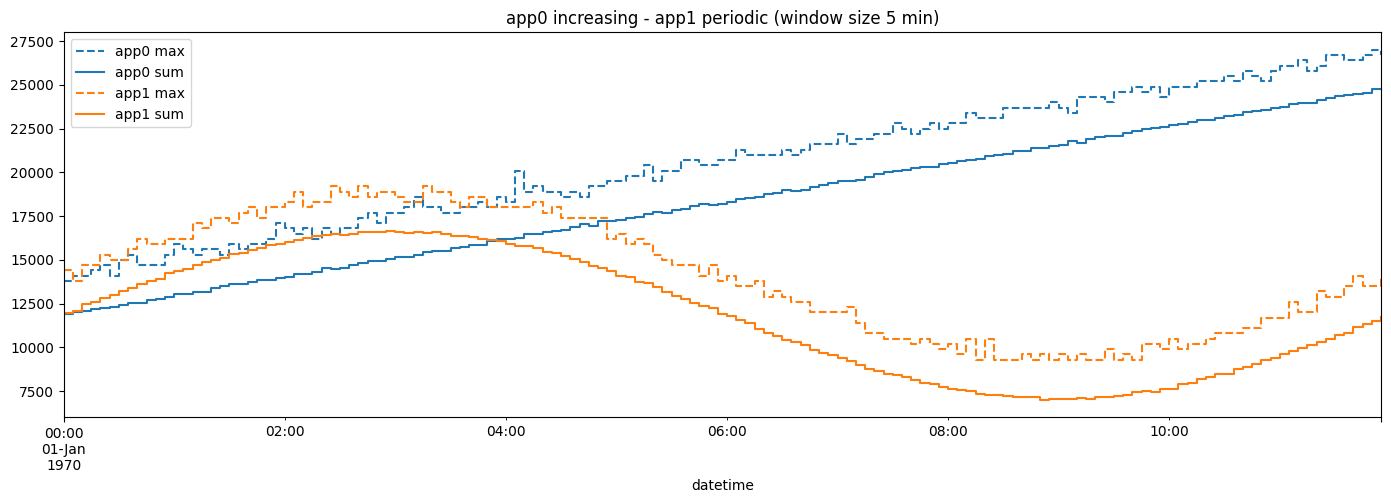

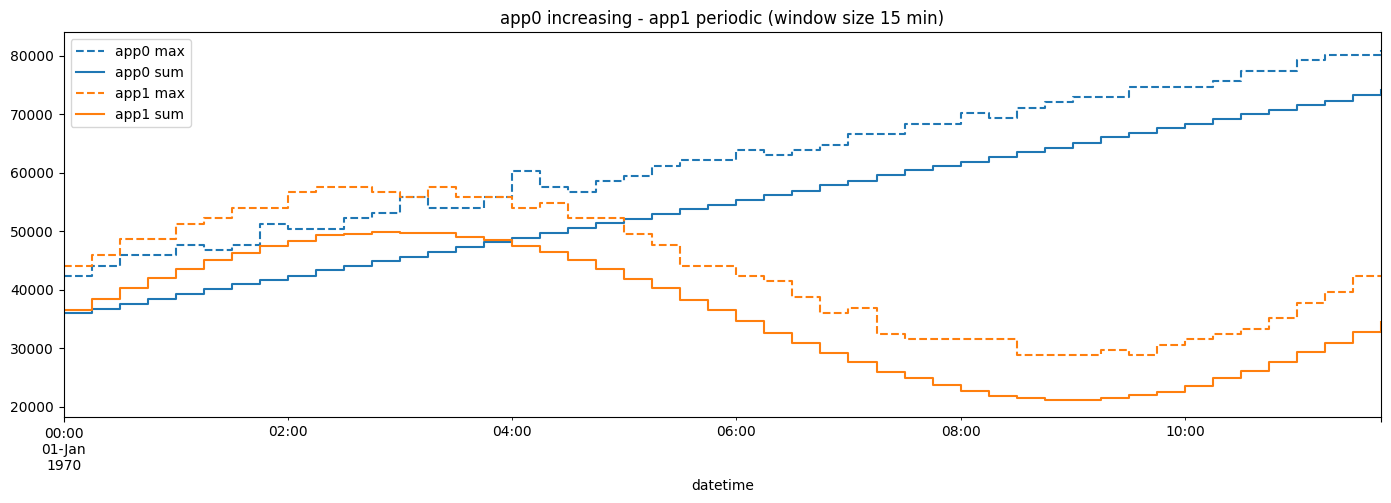

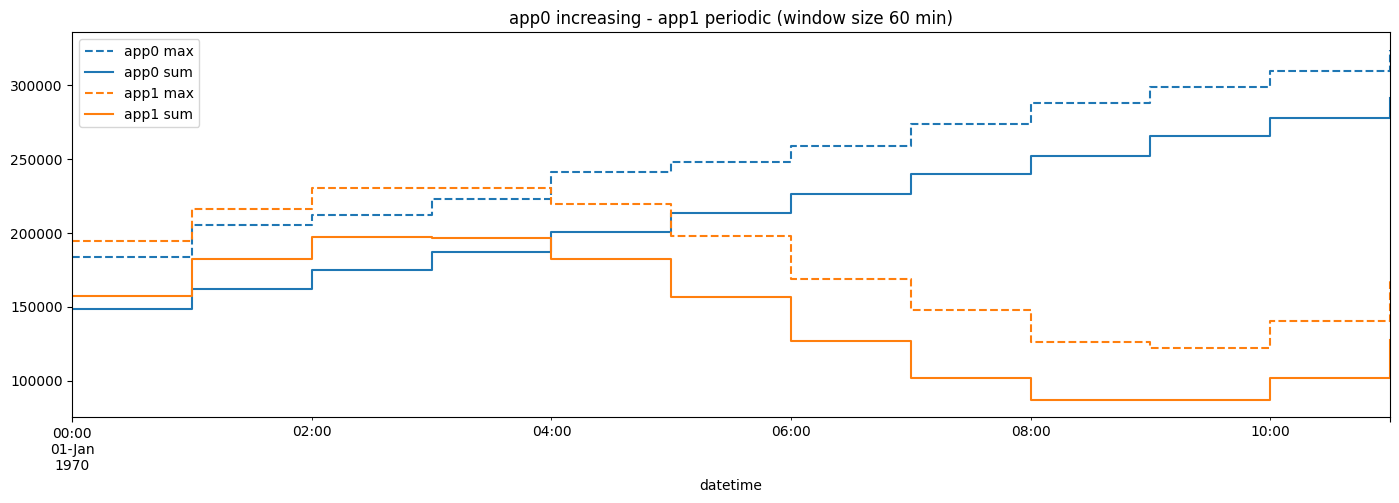

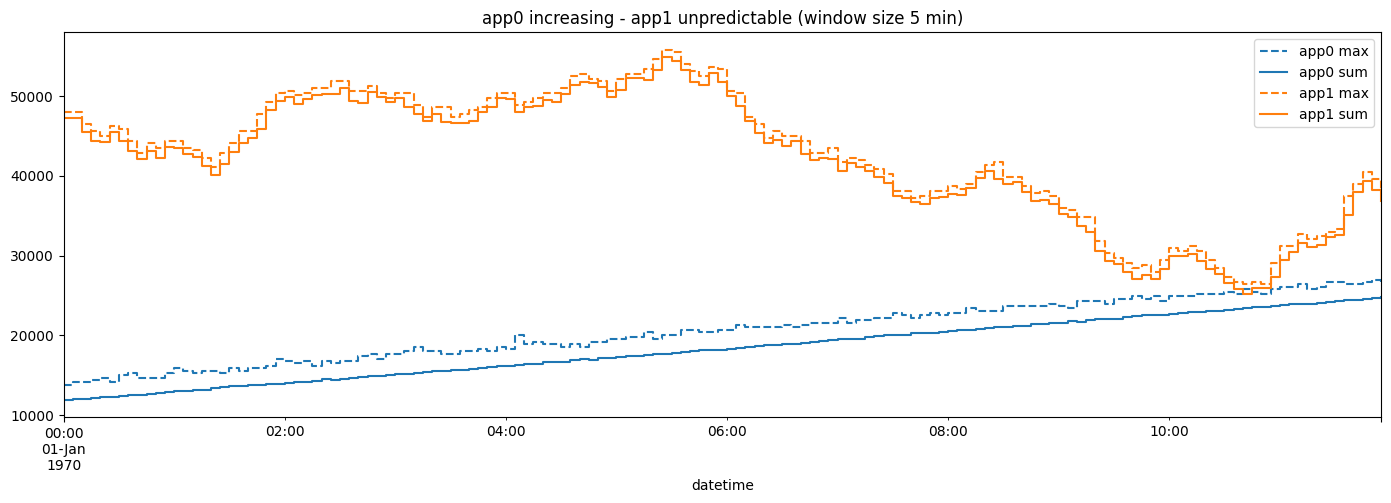

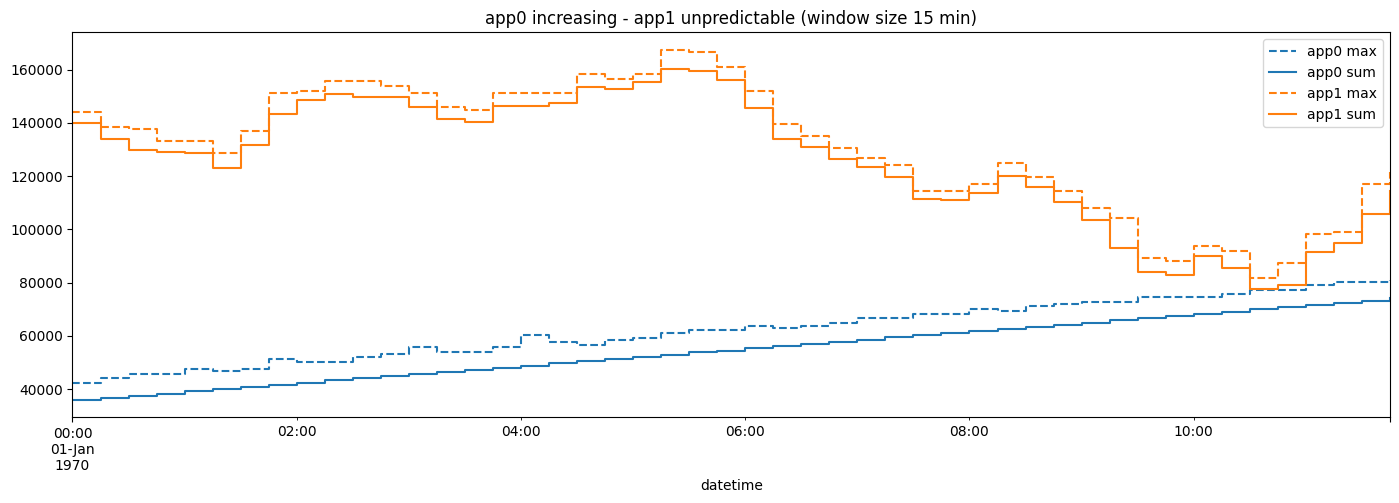

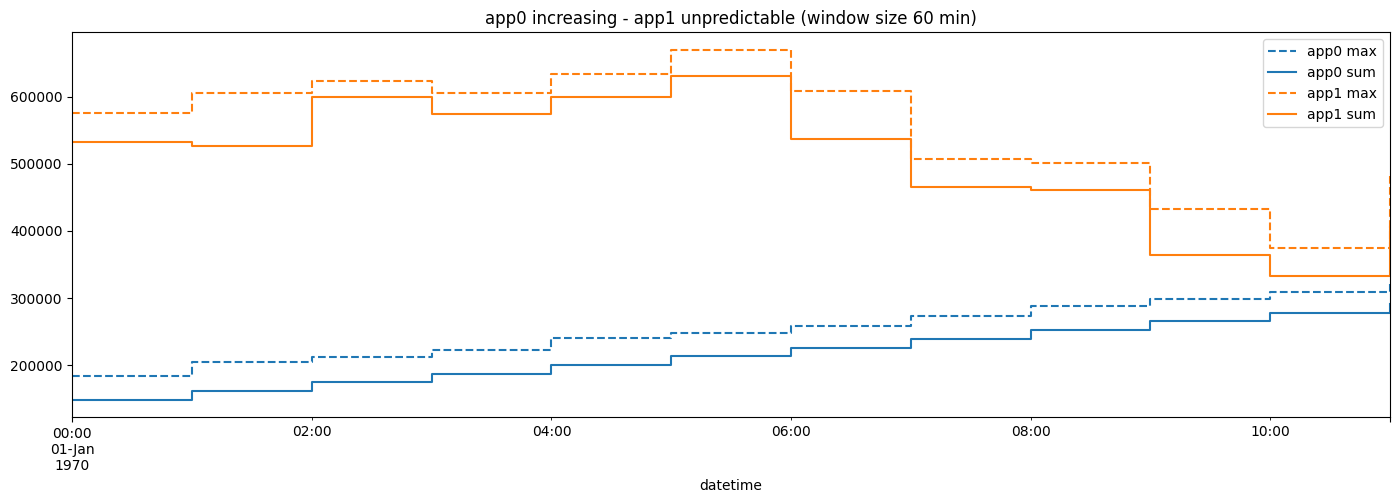

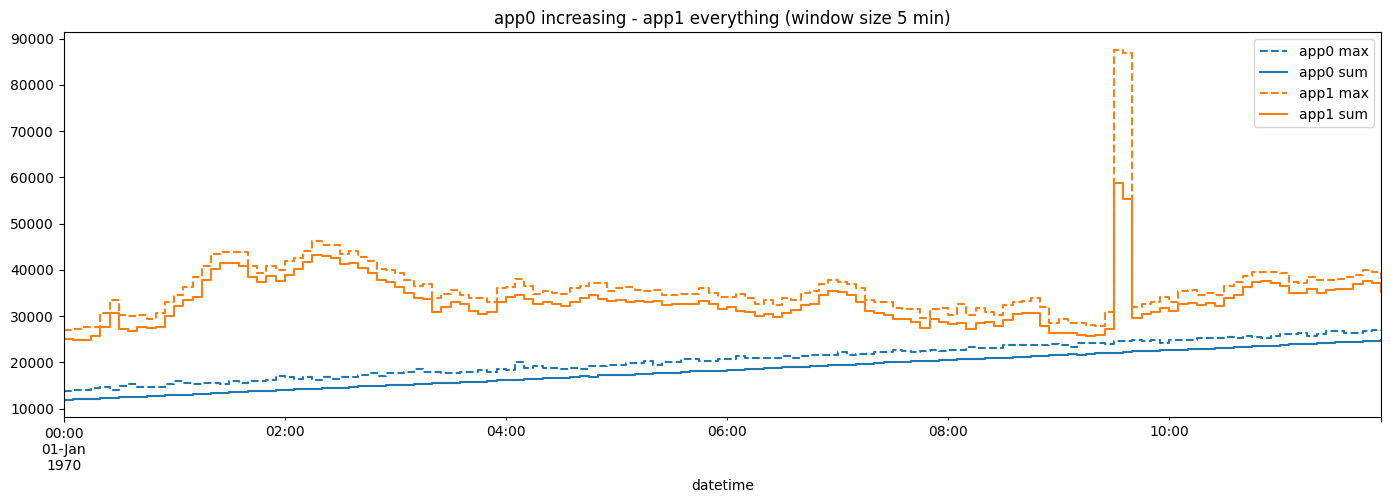

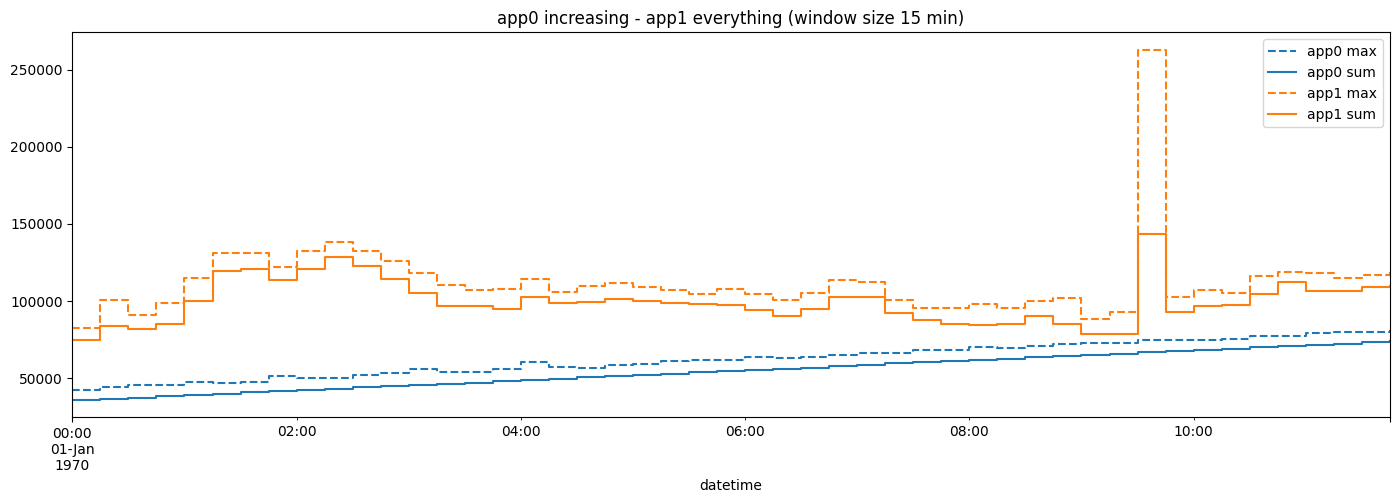

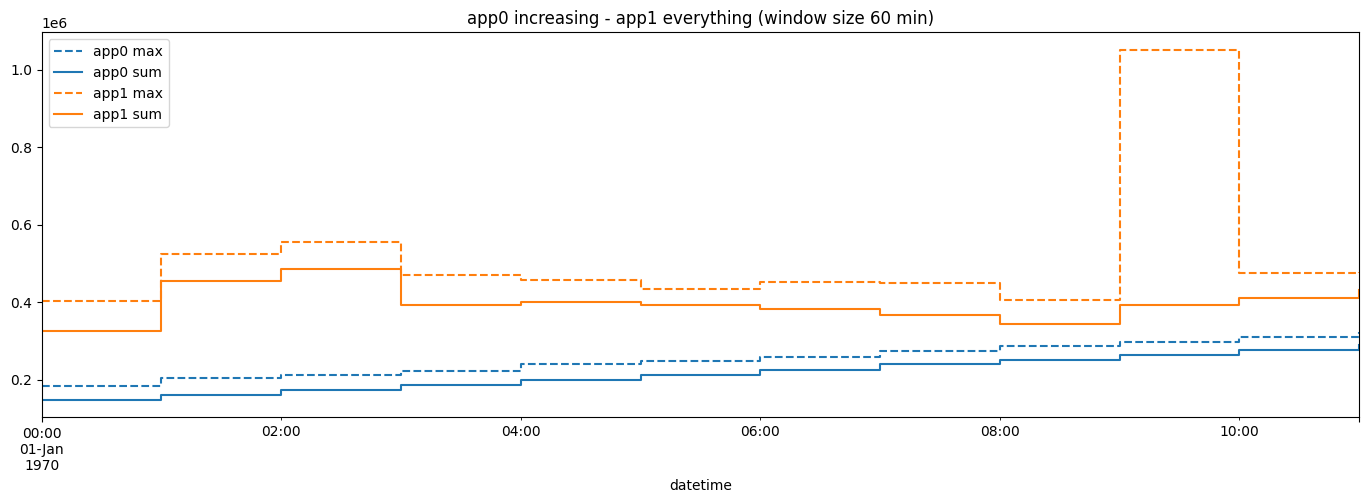

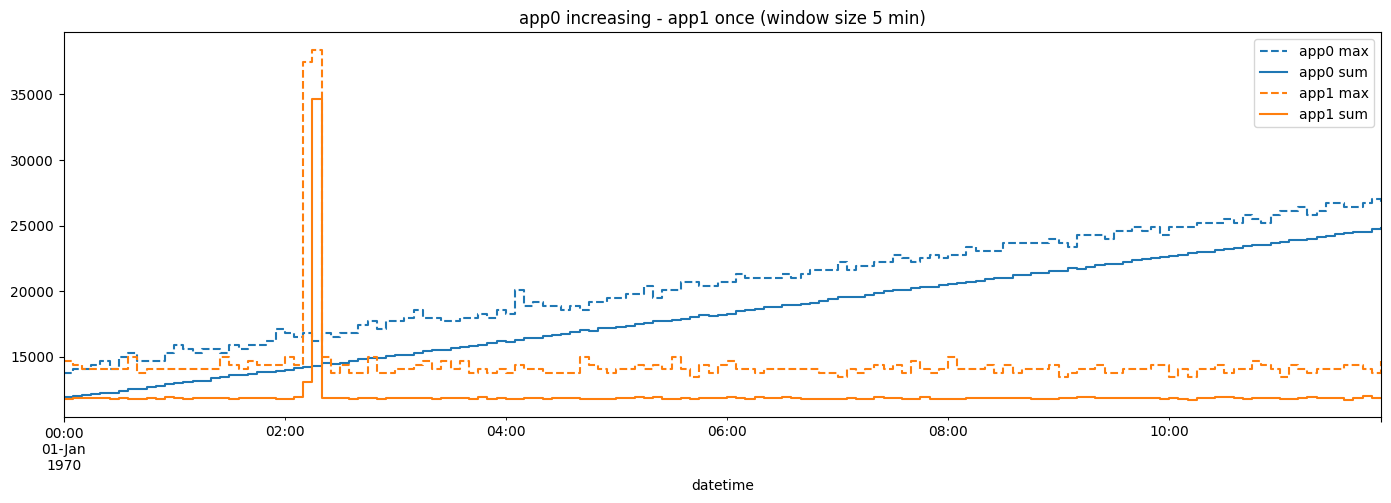

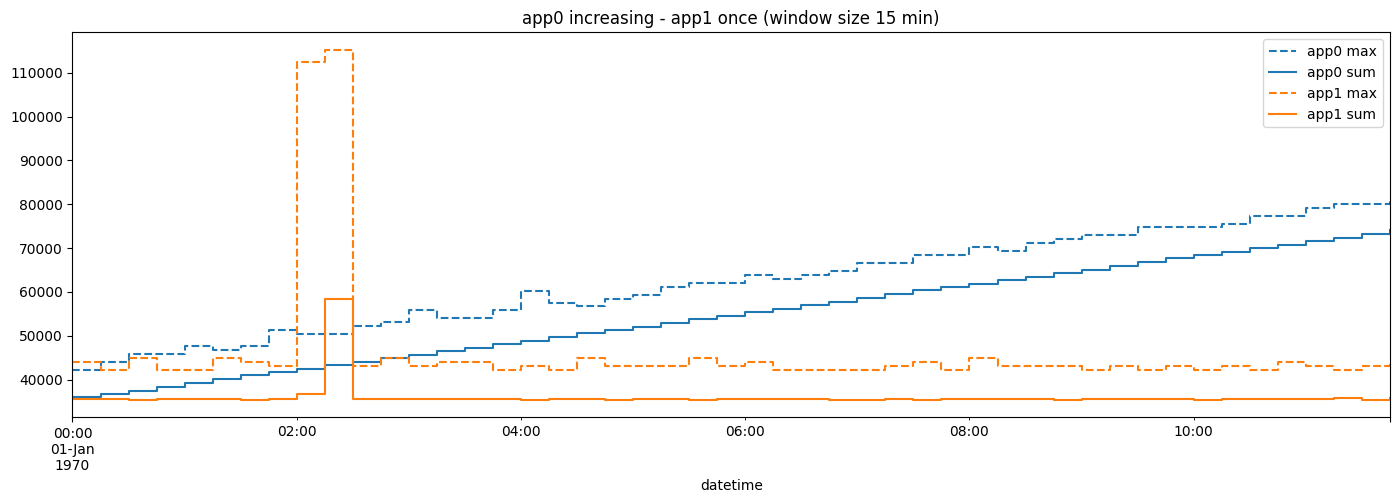

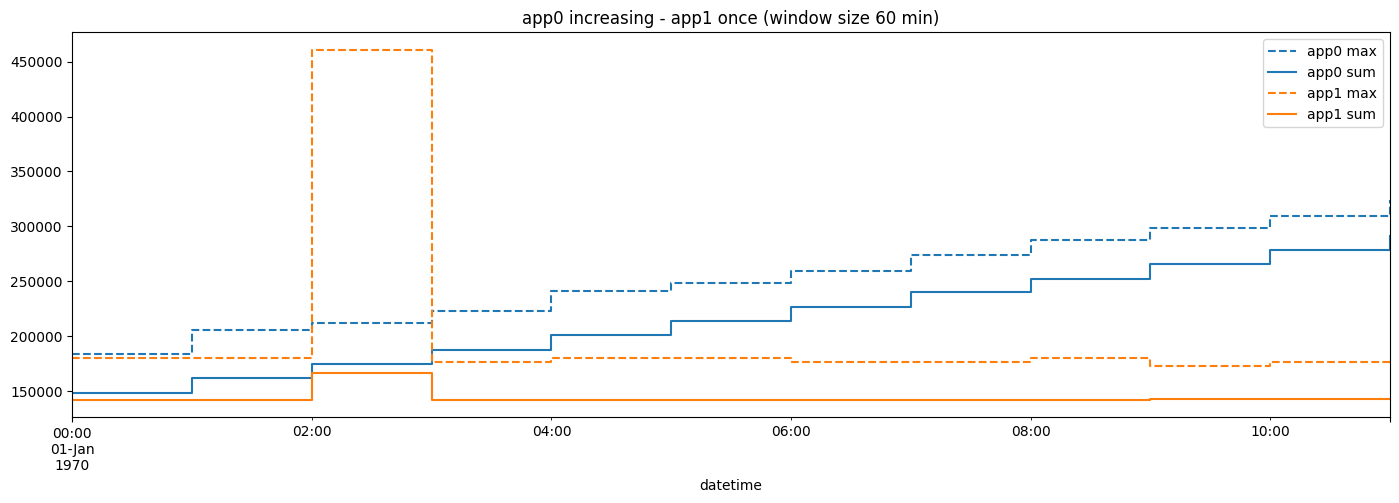

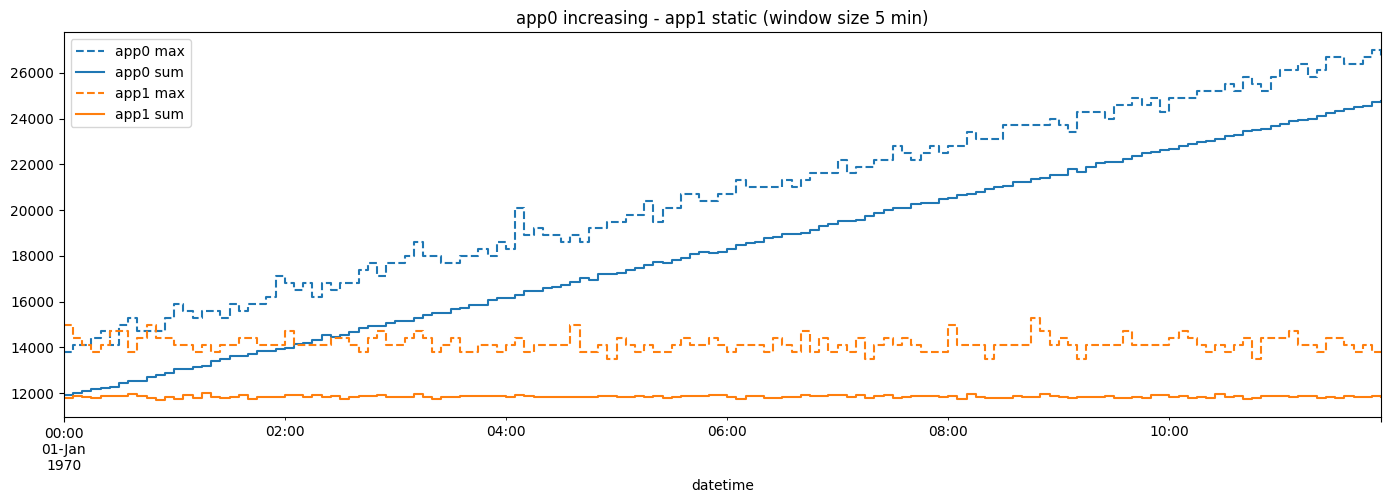

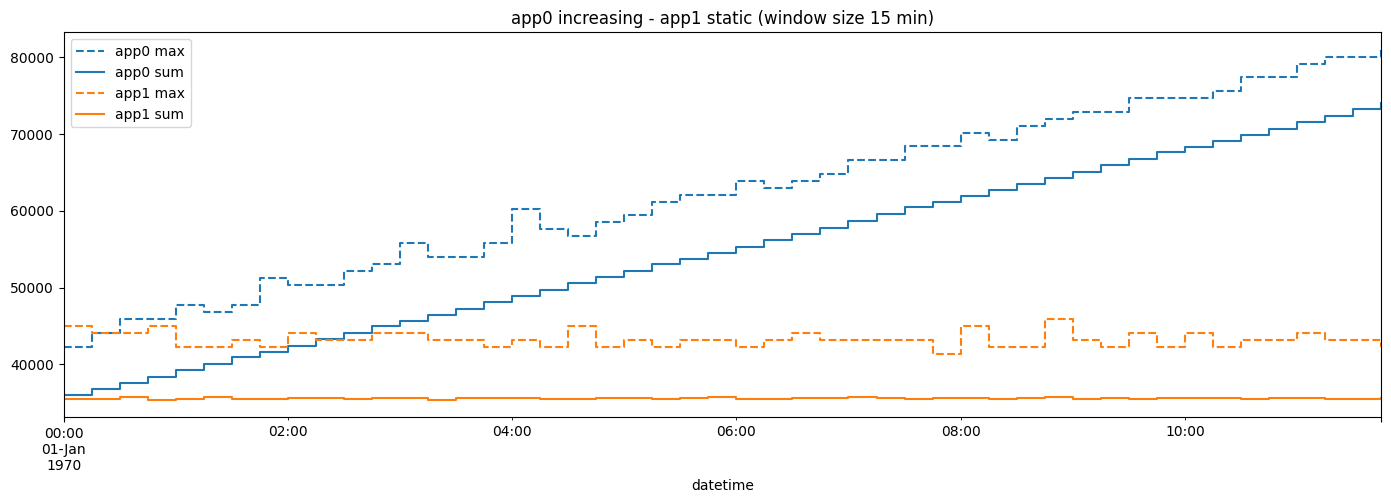

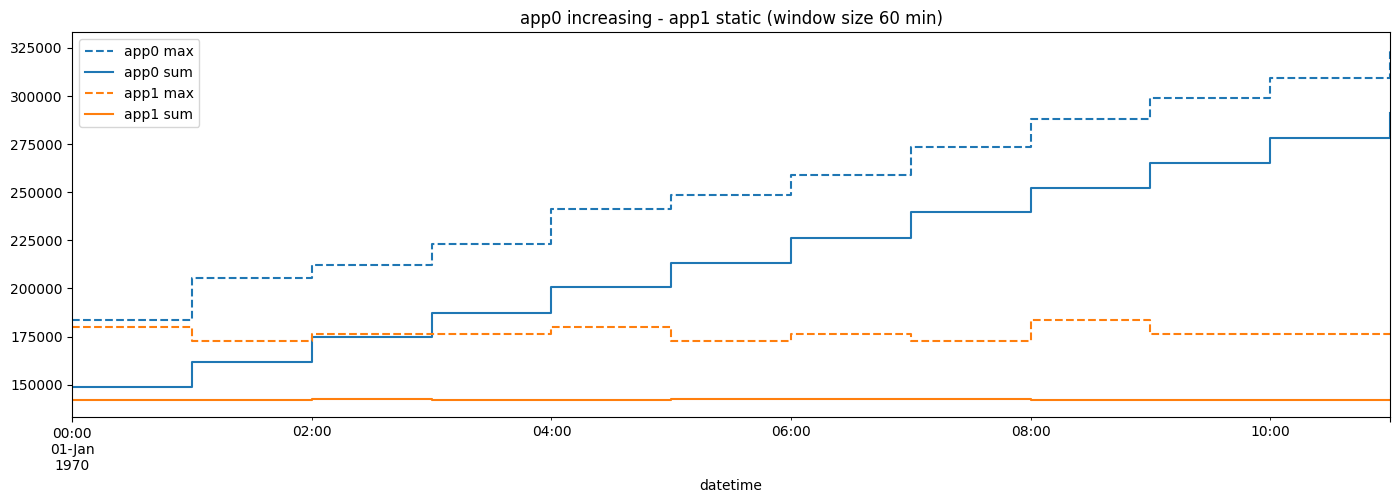

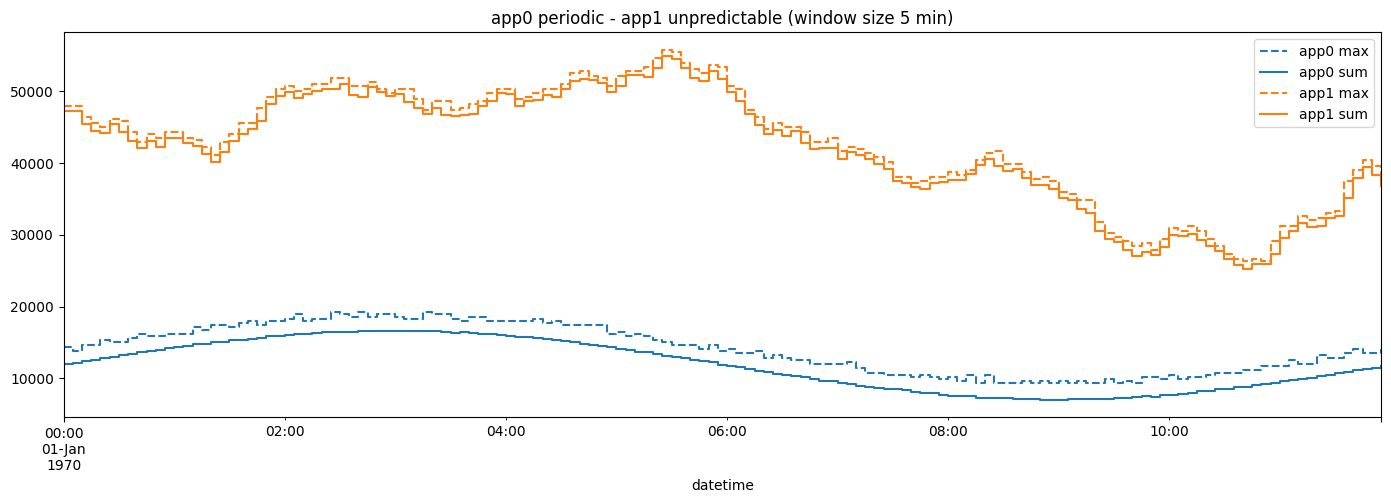

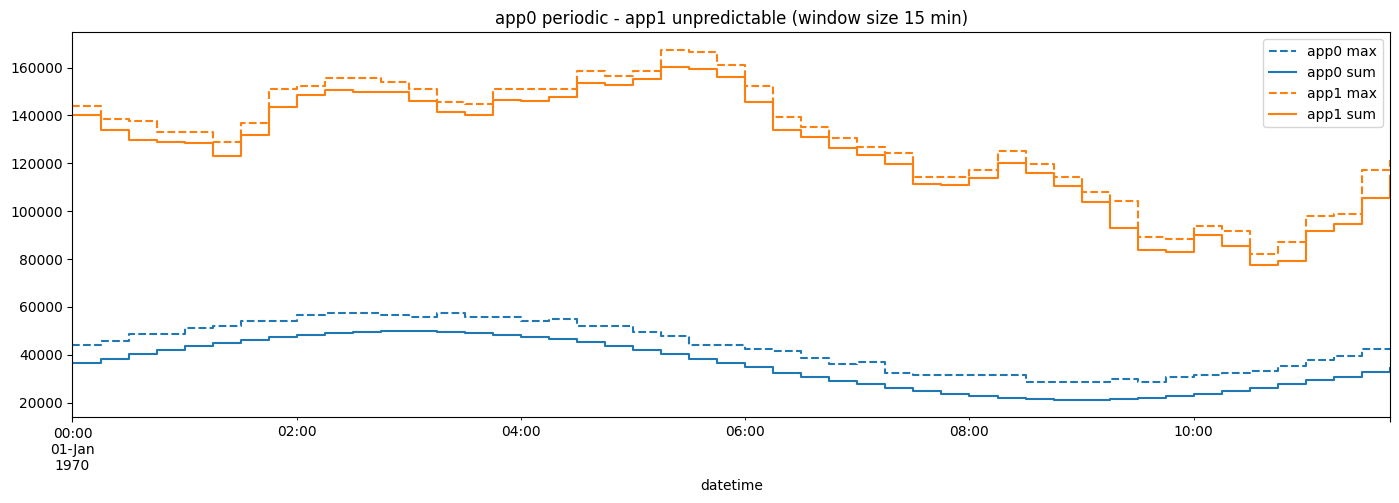

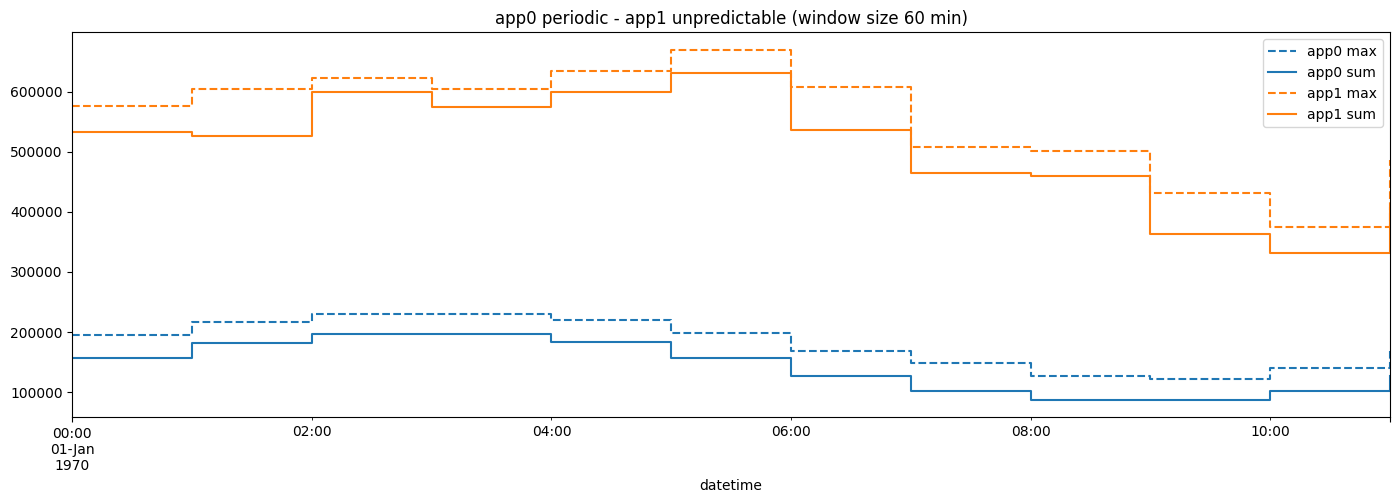

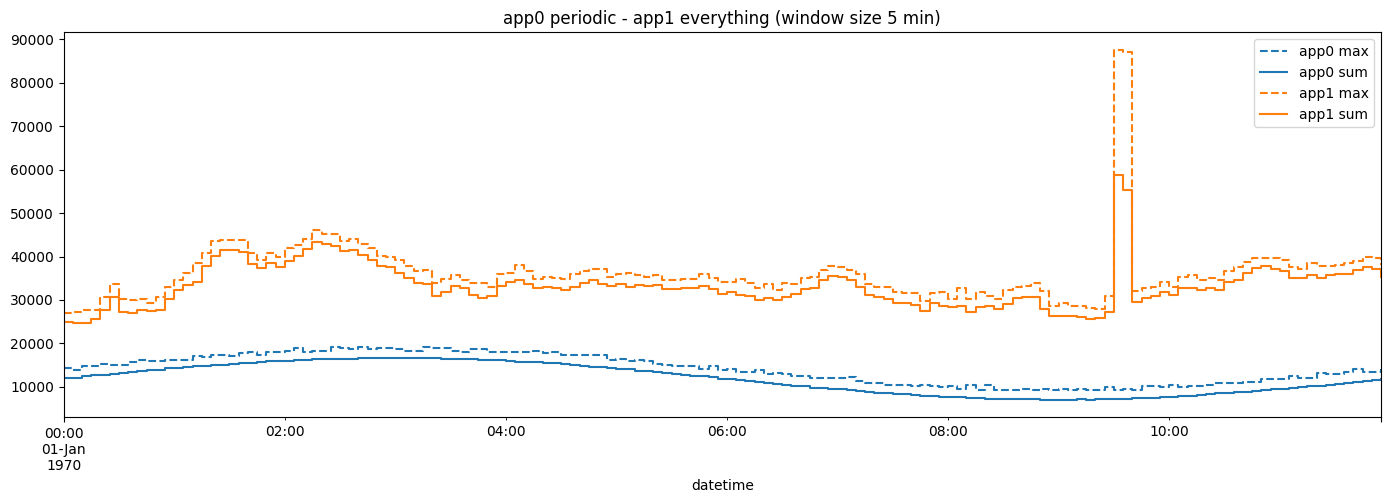

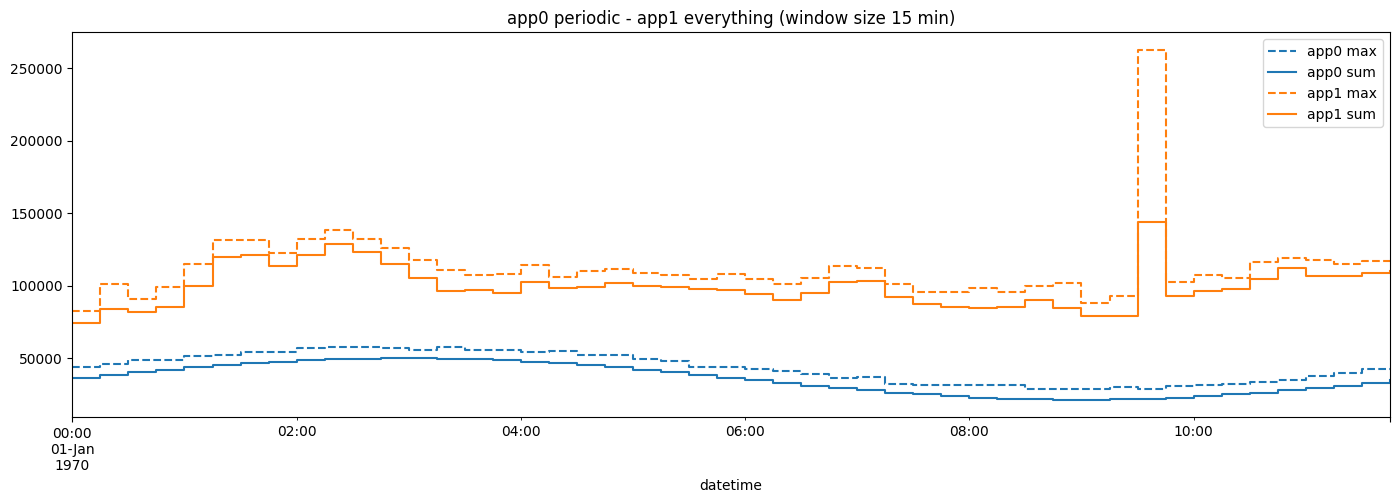

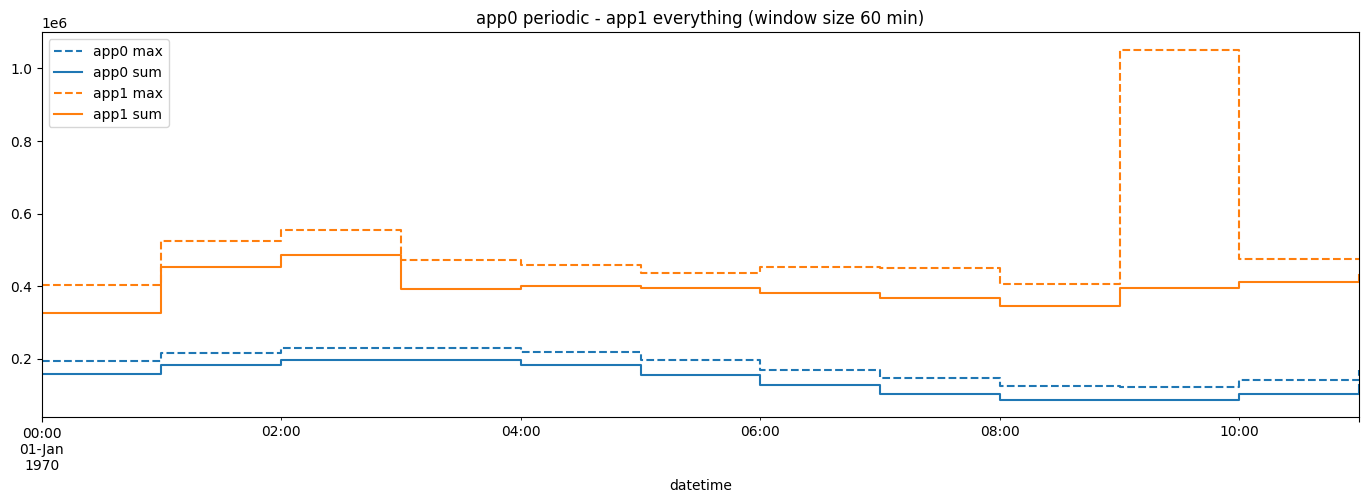

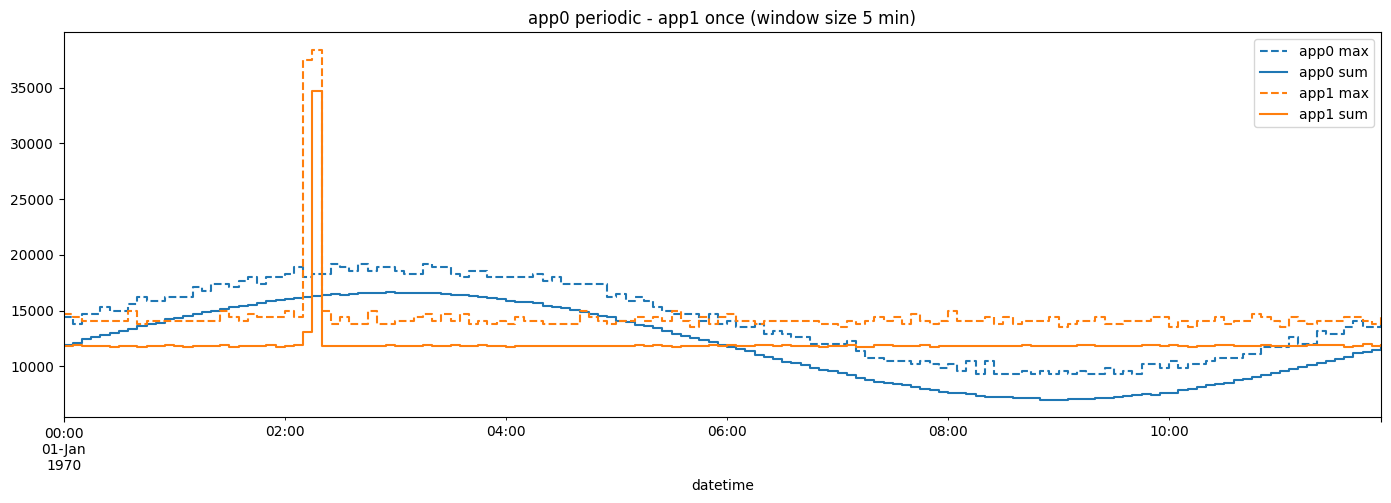

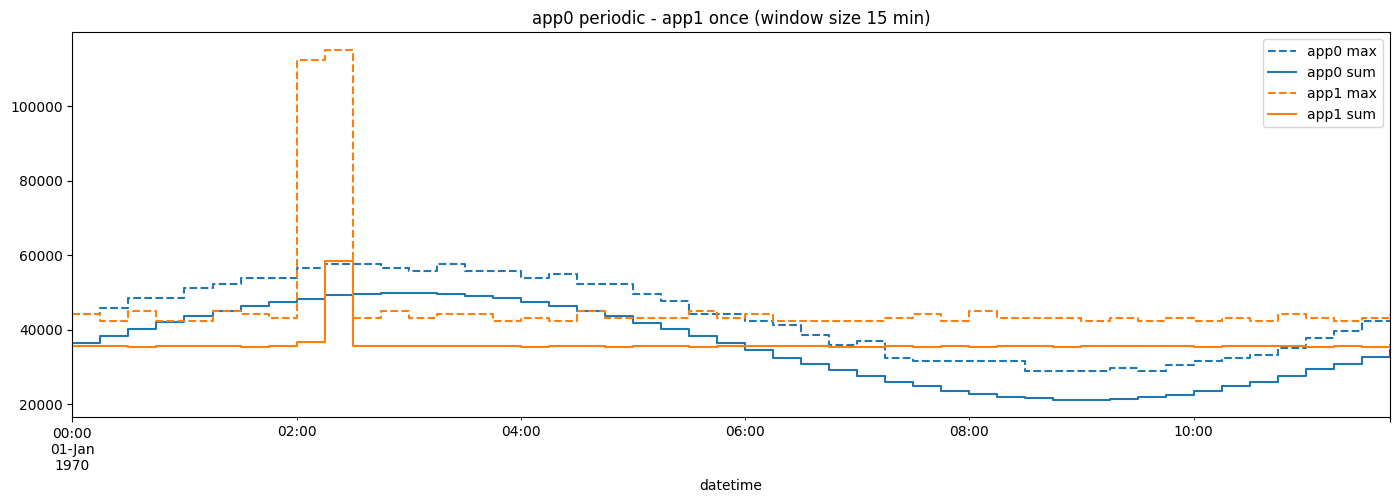

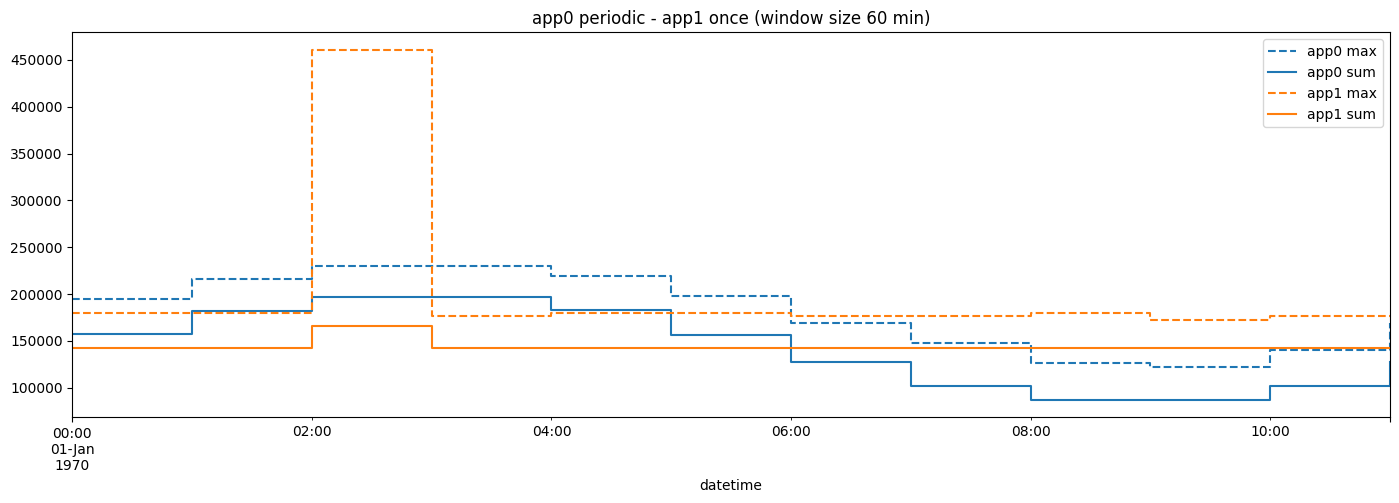

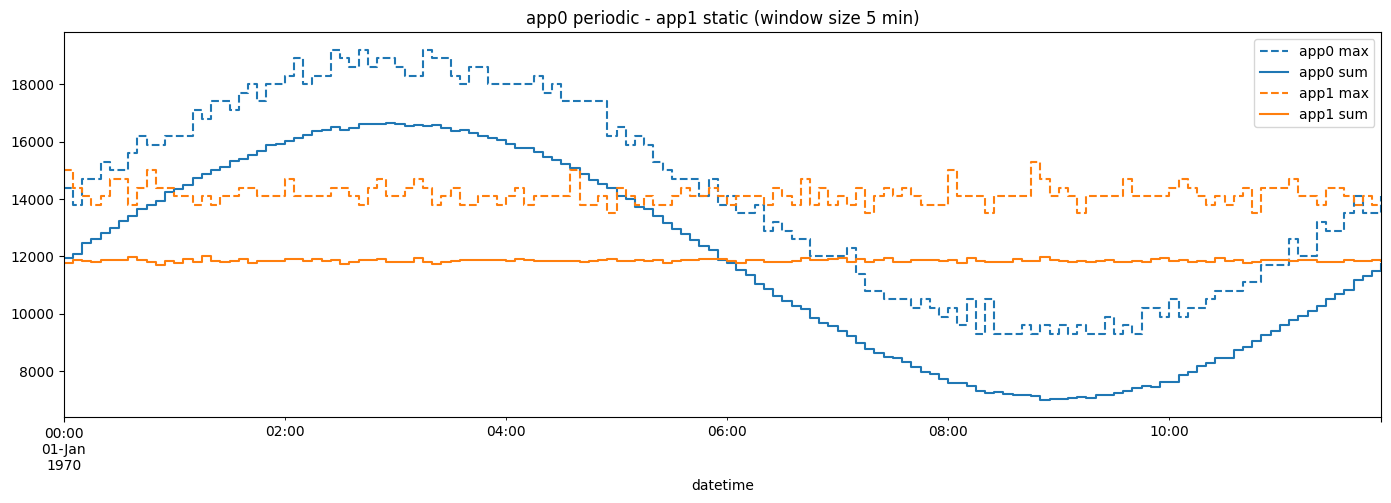

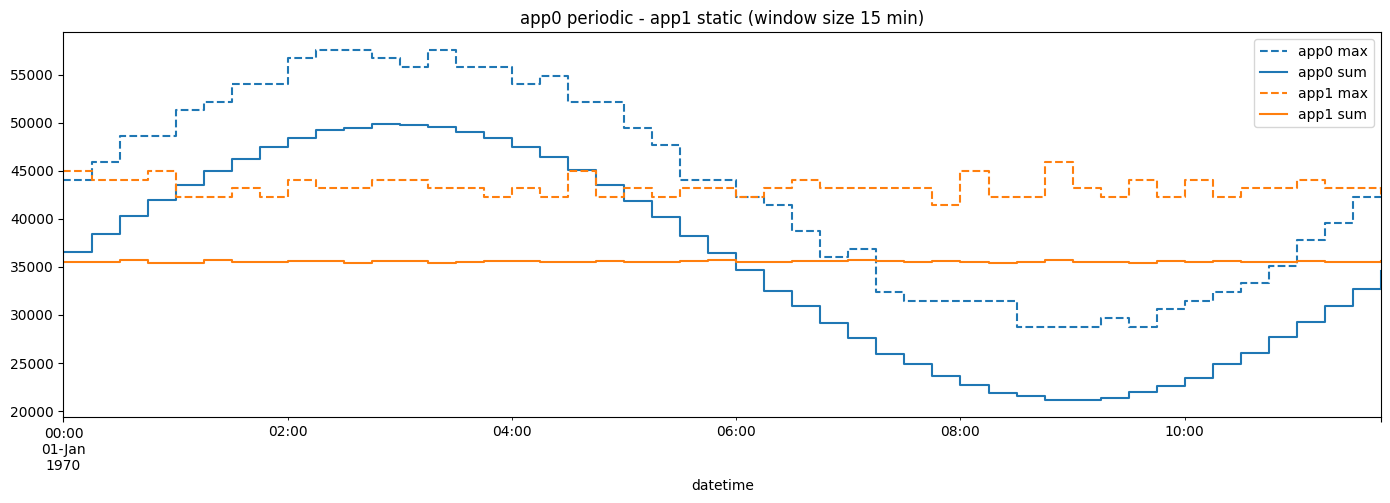

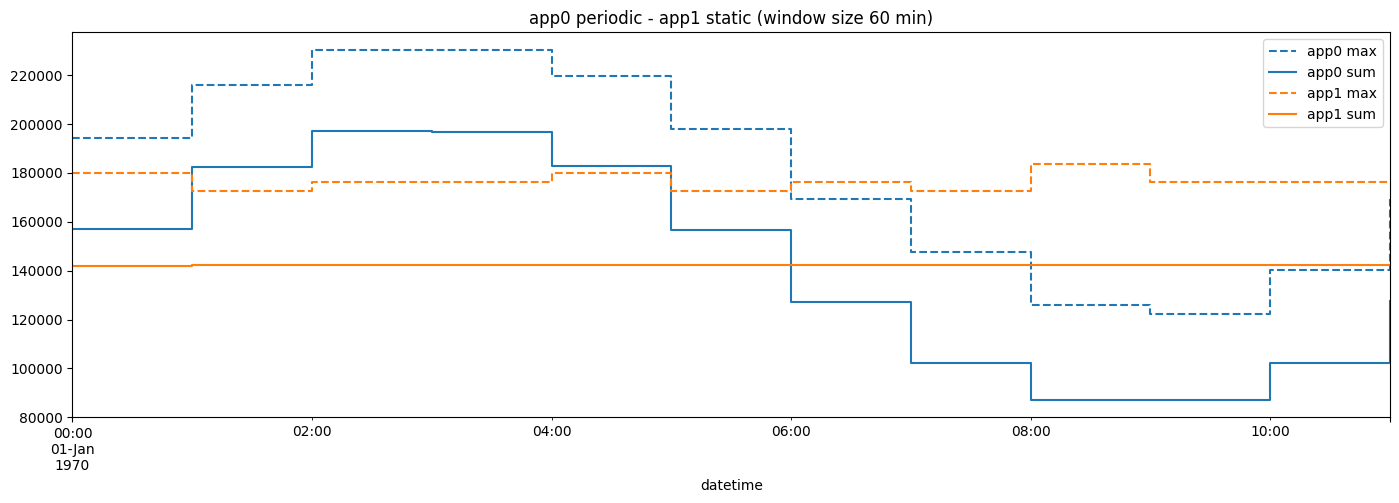

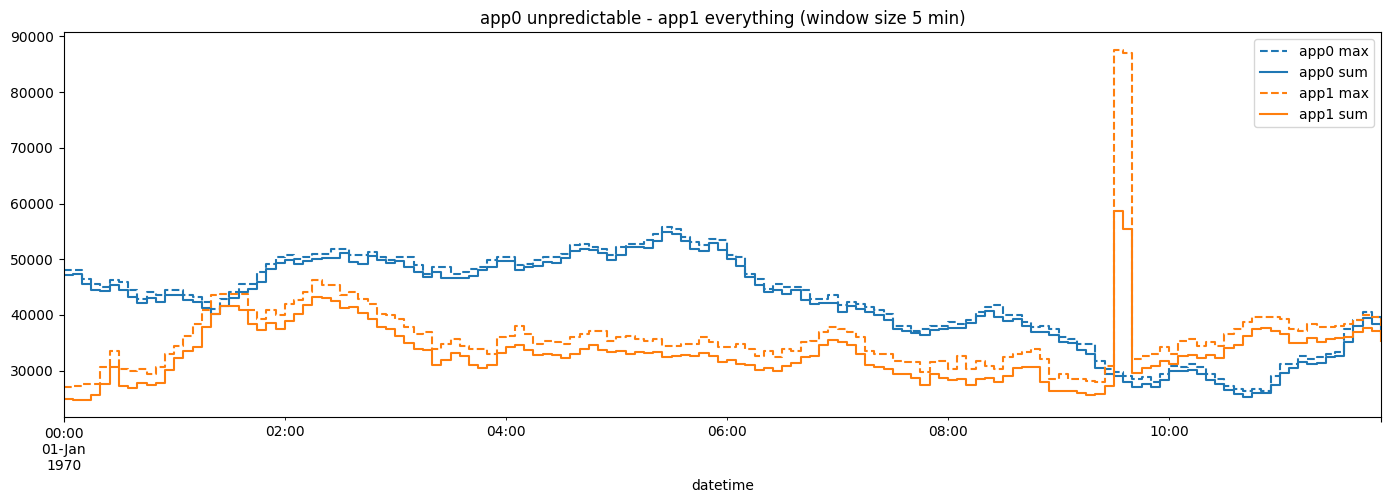

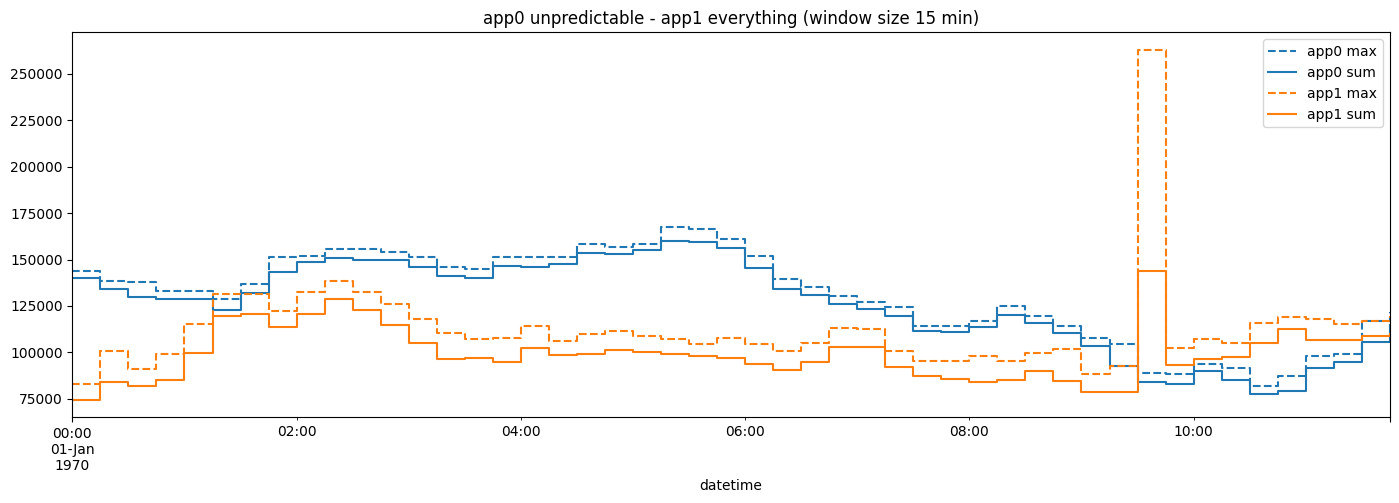

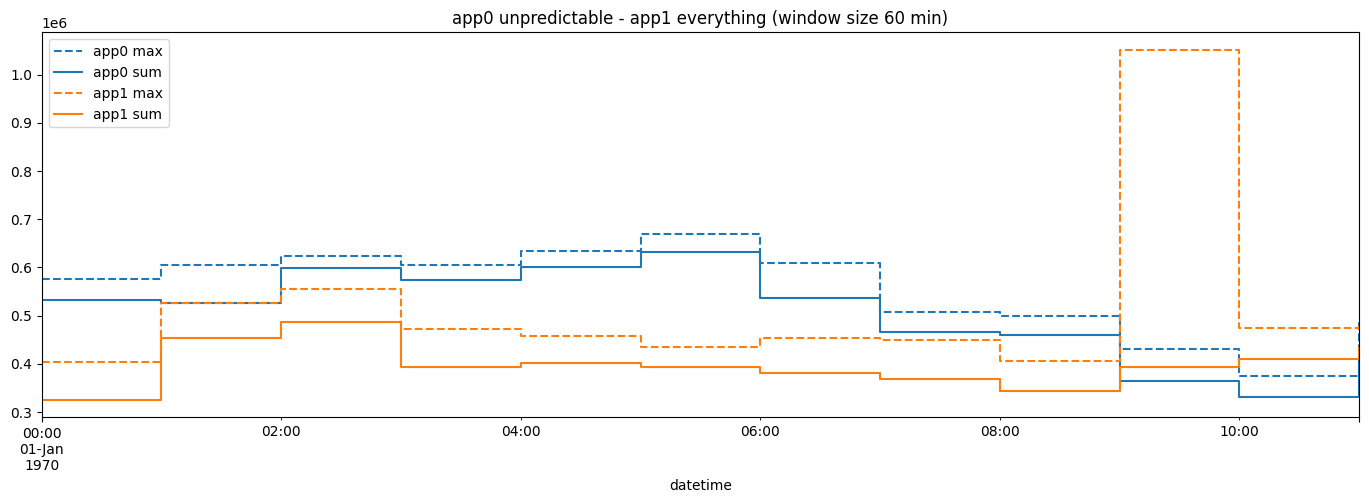

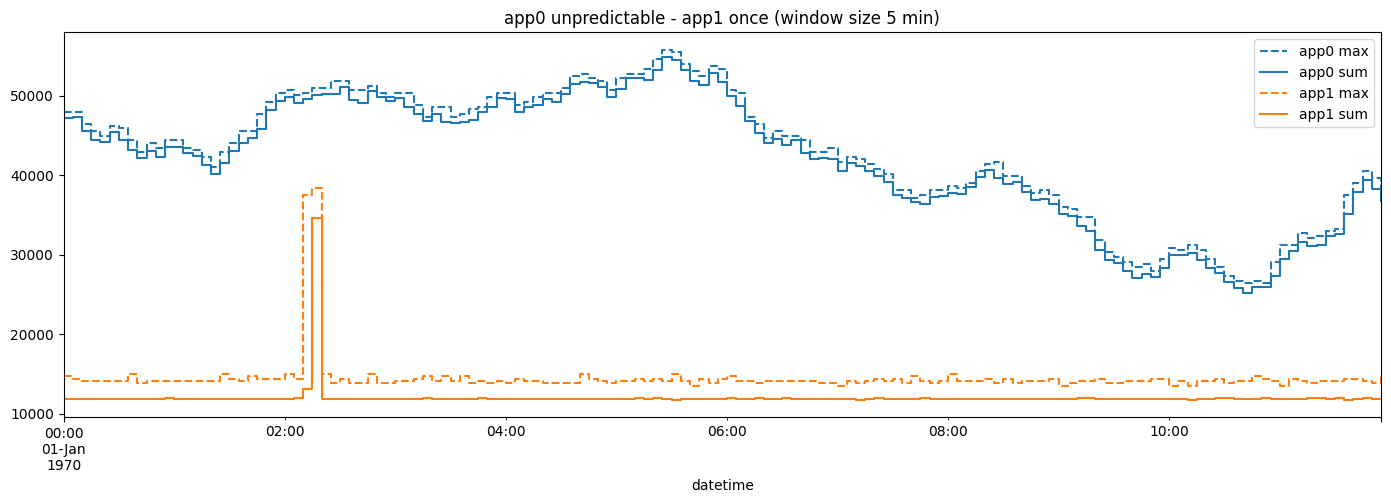

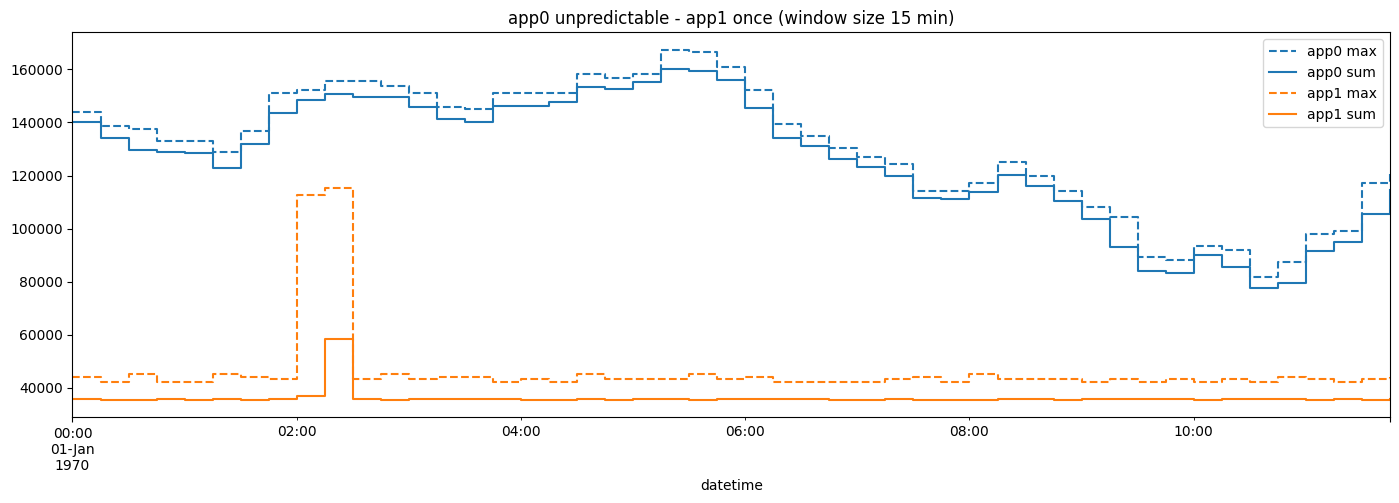

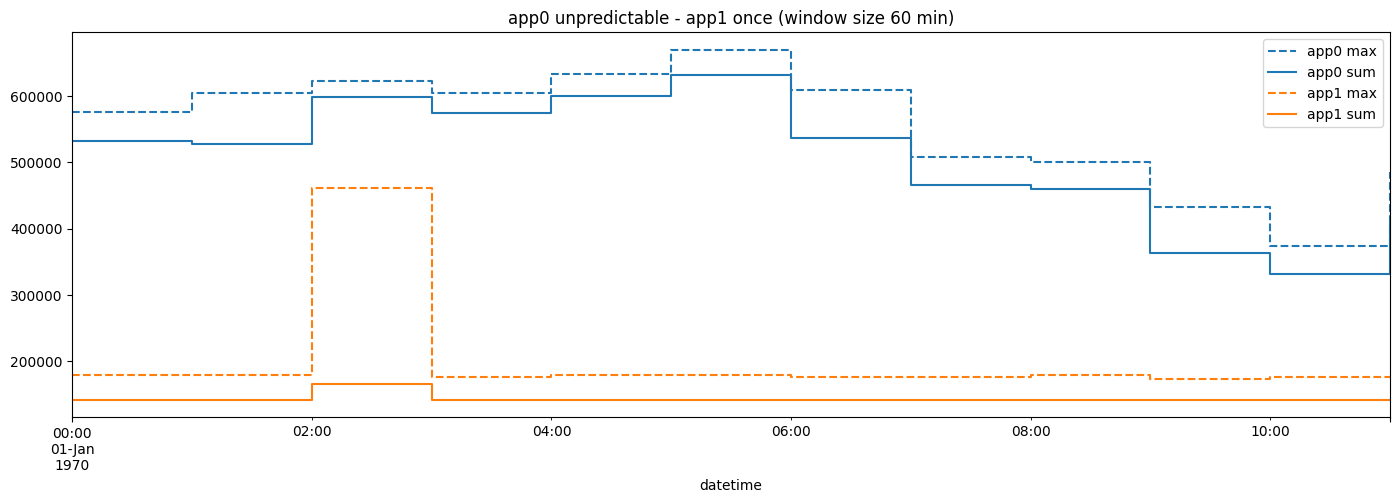

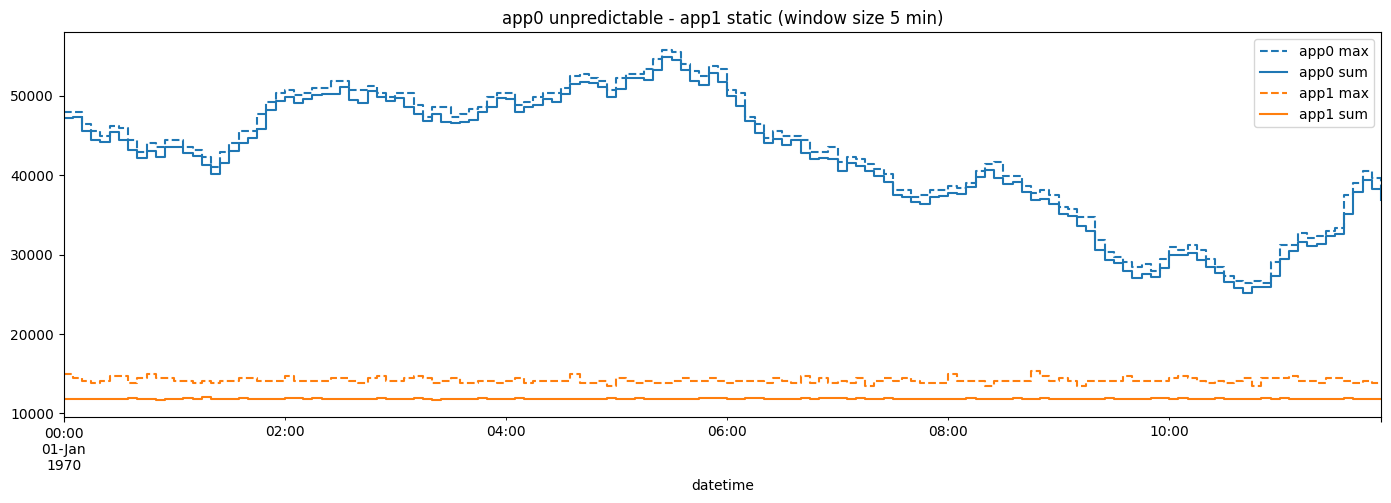

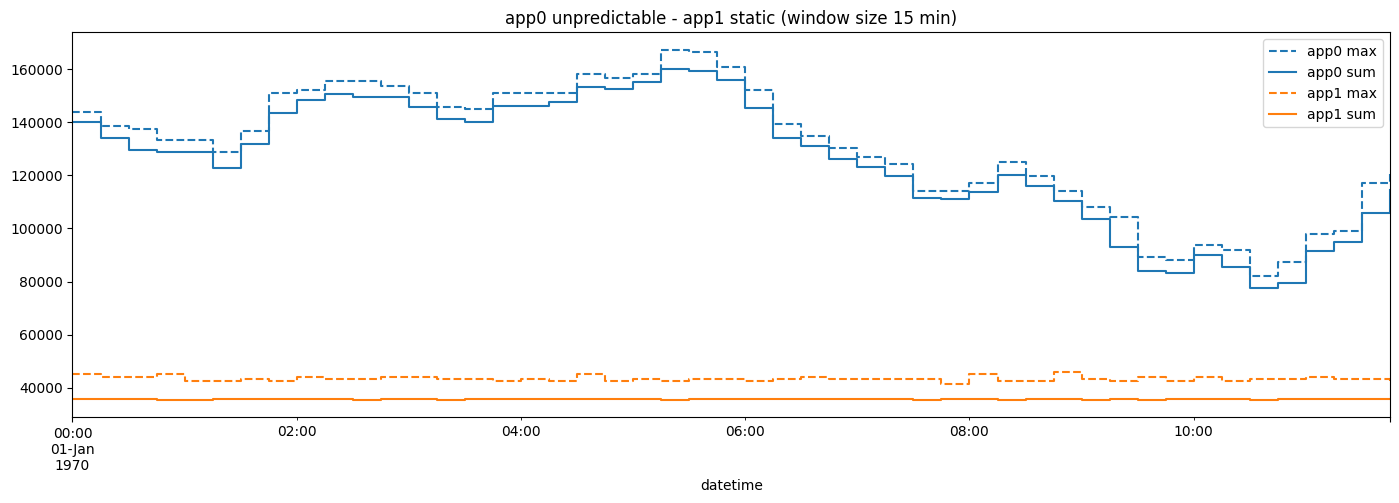

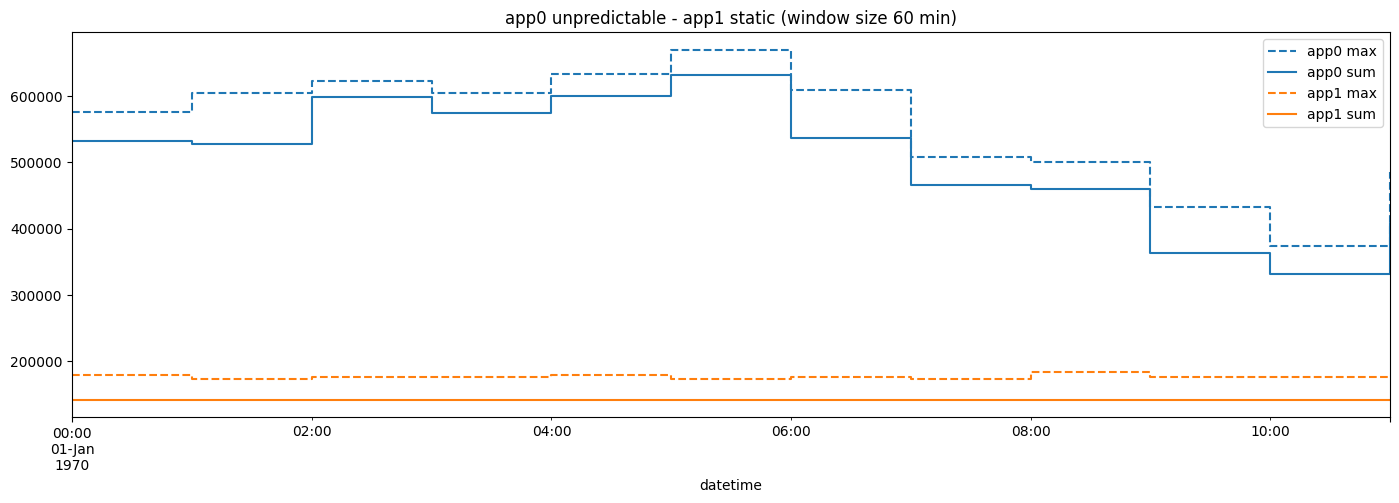

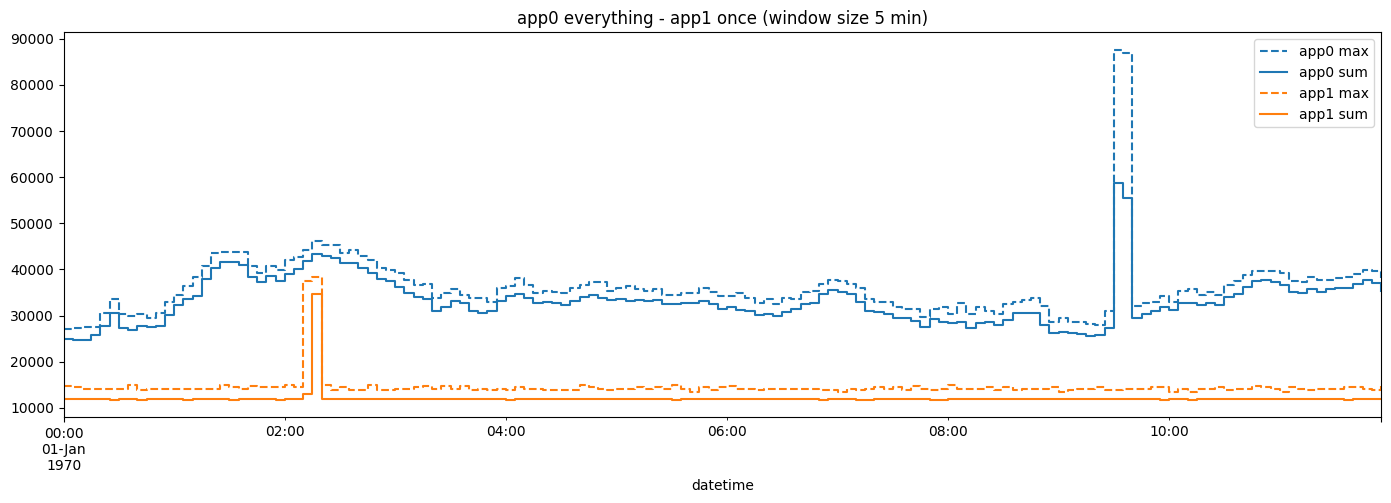

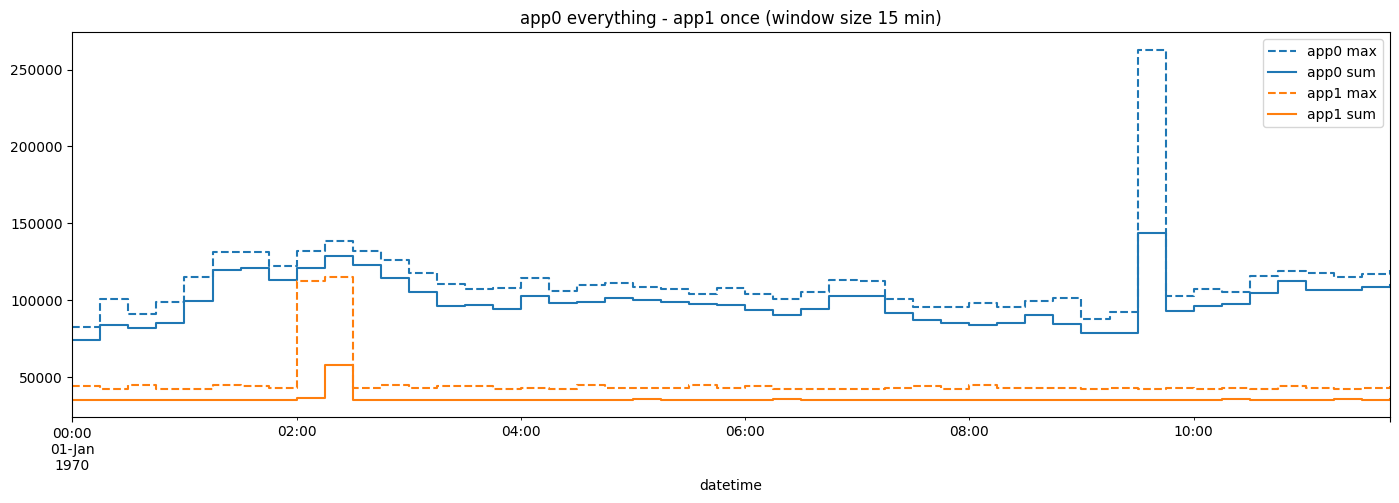

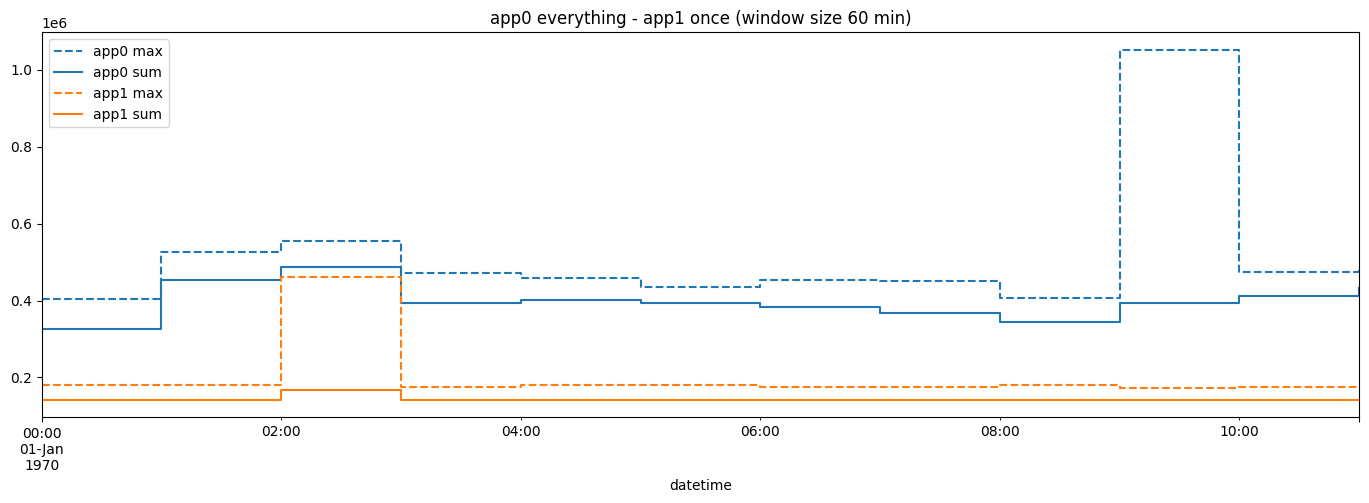

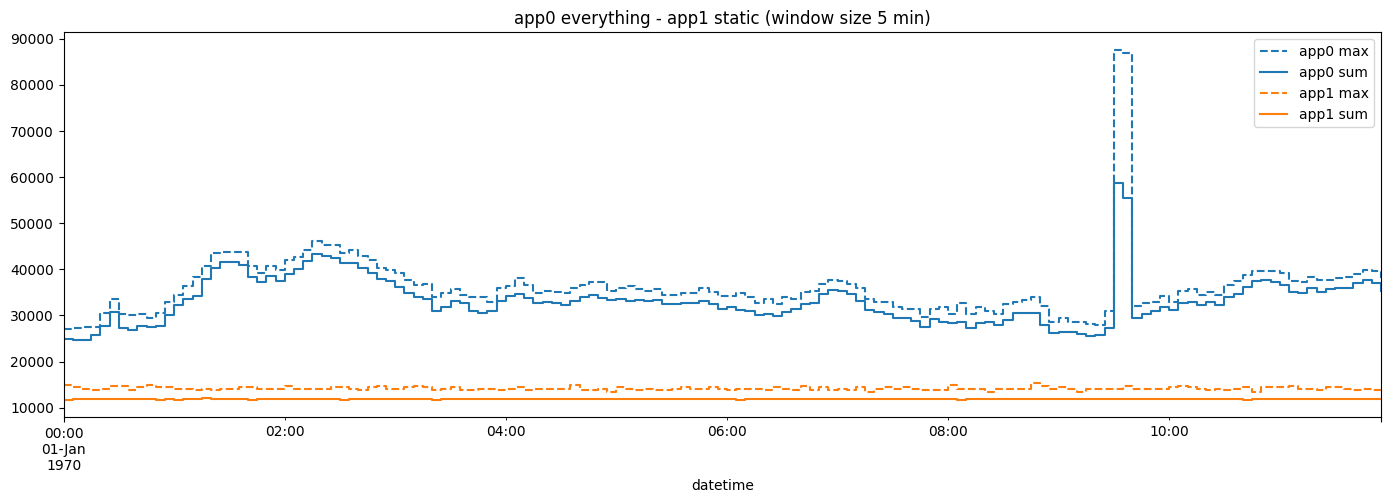

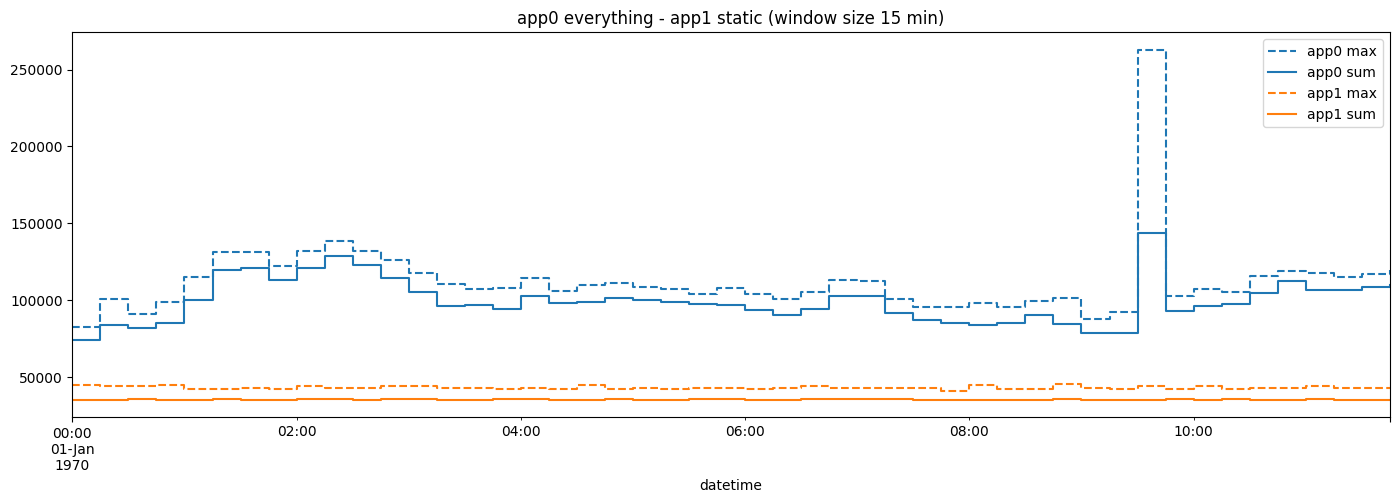

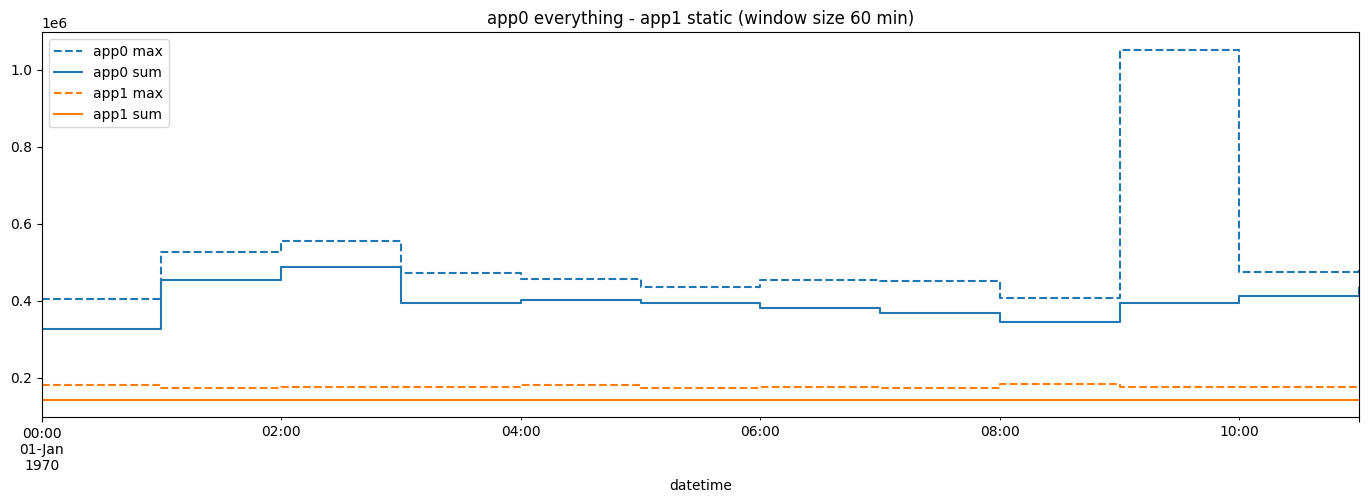

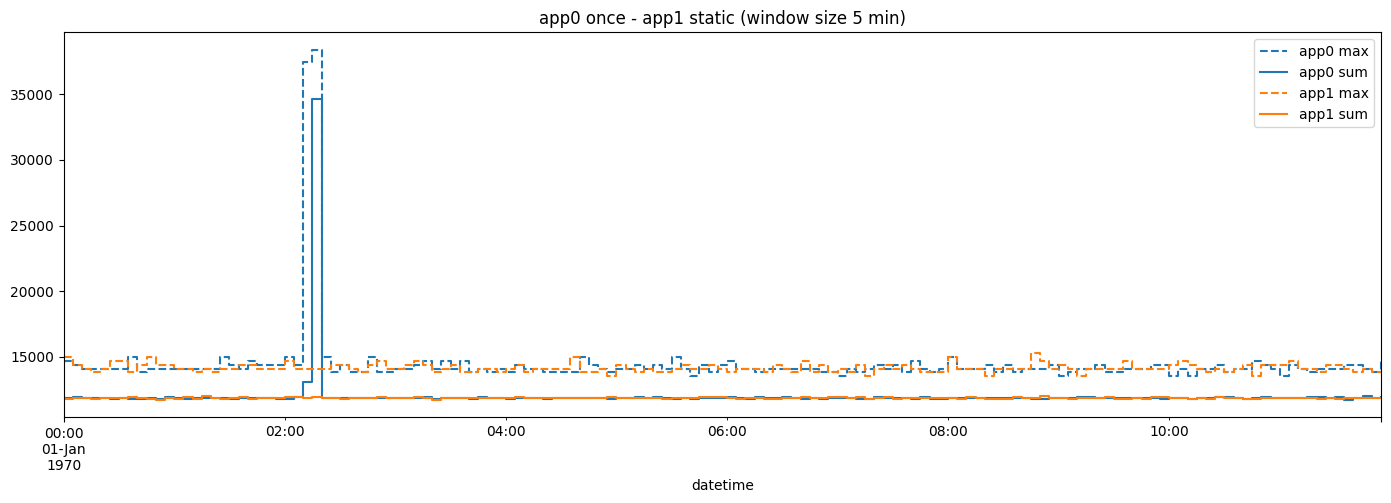

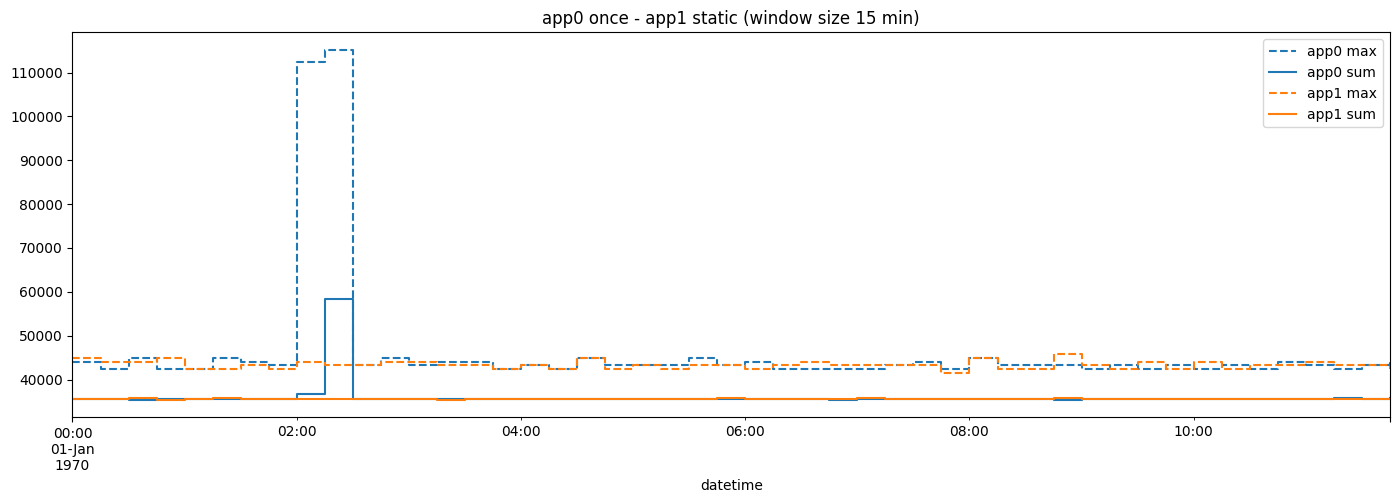

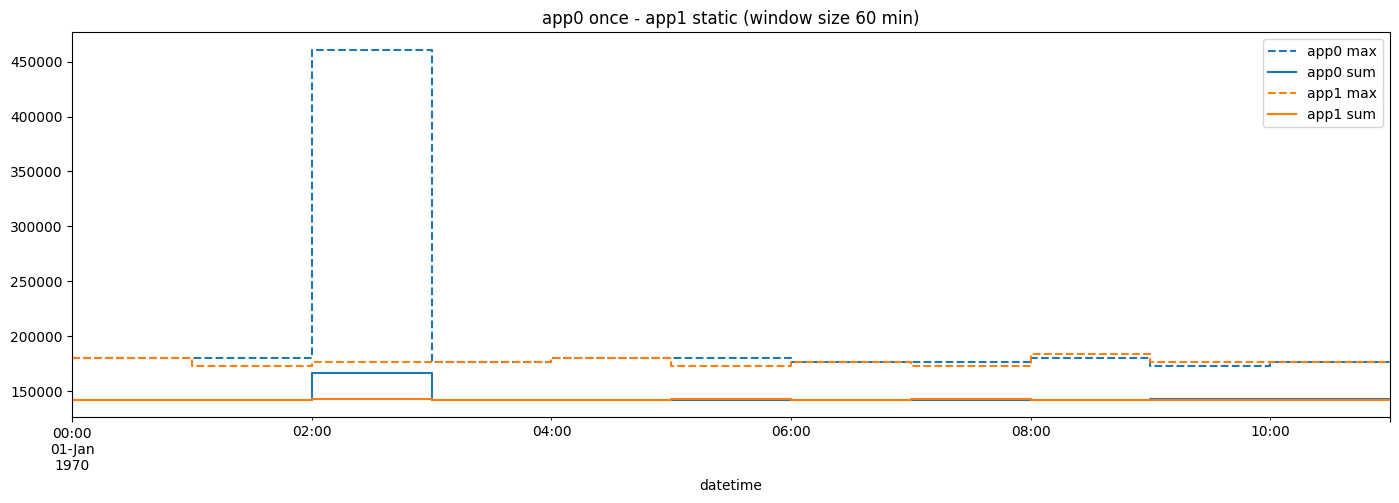

In [12]:
# Plot the first 12 hours of the aggregated dataframes
color = {
    "app0": "tab:blue",
    "app1": "tab:orange",
}
style = {
    "max": "--",
    "sum": "-",
}
for trace1, trace2 in traces_app_scenario:
    for window_size in window_sizes_min:
        zoom = 12 * 60 // window_size
        fig, ax = plt.subplots(figsize=(17, 5))
        for app in ["app0", "app1"]:
            for agg_func in ["max", "sum"]:
                s_app = df_agg_2apps[(trace1, trace2)][(window_size, agg_func)].iloc[
                    :zoom
                ][app]
                s_app.plot(
                    ax=ax,
                    label=f"{app} {agg_func}",
                    style=style[agg_func],
                    color=color[app],
                    drawstyle="steps-post",
                )

        plt.title(f"app0 {trace1} - app1 {trace2} (window size {window_size} min)")
        plt.legend()